# **GCNN for Topic Classification using Link Prediction**

This colab notebook contains the pipeline of a GCNN predicting the classes of the Open Data Barcelona datasets.

This GCNN uses link prediction in order to find datasets of the same topic. If two datasets are linked, this would eventually mean that they share the same class. This way, we can use the datasets of which we already know the class to predict the class of unknown datasets. 

In addition, the GCNN learns what do the same-class datasets have in common so it can predict new links to add datasets to a specific class.

The classes have been mapped into numbers to ease the process. We have the following: 

- Administracio: 1
- Ciutat i Serveis: 2
- Economia: 3
- Poblacio: 4
- Territori: 5

**STEP 0: Importing packages and installing requirements**

---



In [ ]:
!pip install numpy scipy matplotlib tensorboard open3d==0.9.0 opencv-python
!pip install "rtree>=0.8,<0.9"
!pip install "trimesh[easy]"

!pip install https://download.pytorch.org/whl/cu101/torch-1.6.0%2Bcu101-cp37-cp37m-linux_x86_64.whl
!pip install https://download.pytorch.org/whl/cu101/torchvision-0.7.0%2Bcu101-cp37-cp37m-linux_x86_64.whl
!pip install torch-scatter==latest+cu101 -f https://pytorch-geometric.com/whl/torch-1.6.0.html
!pip install torch-sparse==latest+cu101 -f https://pytorch-geometric.com/whl/torch-1.6.0.html
!pip install torch-cluster==latest+cu101 -f https://pytorch-geometric.com/whl/torch-1.6.0.html
!pip install torch-spline-conv==latest+cu101 -f https://pytorch-geometric.com/whl/torch-1.6.0.html
!pip install torch-geometric
!pip install networkx

Looking in links: https://pytorch-geometric.com/whl/torch-1.6.0.html
  Using cached https://pytorch-geometric.com/whl/torch-1.6.0/torch_scatter-latest%2Bcu101-cp37-cp37m-linux_x86_64.whl
  Found existing installation: torch-scatter 2.0.5
    Uninstalling torch-scatter-2.0.5:
      Successfully uninstalled torch-scatter-2.0.5
Looking in links: https://pytorch-geometric.com/whl/torch-1.6.0.html
  Using cached https://pytorch-geometric.com/whl/torch-1.6.0/torch_sparse-latest%2Bcu101-cp37-cp37m-linux_x86_64.whl
  Found existing installation: torch-sparse 0.6.8
    Uninstalling torch-sparse-0.6.8:
      Successfully uninstalled torch-sparse-0.6.8
Looking in links: https://pytorch-geometric.com/whl/torch-1.6.0.html
  Using cached https://pytorch-geometric.com/whl/torch-1.6.0/torch_cluster-latest%2Bcu101-cp37-cp37m-linux_x86_64.whl
  Found existing installation: torch-cluster 1.5.8
    Uninstalling torch-cluster-1.5.8:
      Successfully uninstalled torch-cluster-1.5.8
Looking in links: https

In [ ]:
import os.path as osp
import argparse
import numpy as np

import torch
import torch.nn.functional as F
from sklearn.metrics import roc_auc_score, average_precision_score, accuracy_score
import torch_geometric.transforms as T
from torch_geometric.nn import GCNConv, ChebConv  
from torch_geometric.data import Data, DataLoader
from torch_geometric.utils import train_test_split_edges
from torch_geometric.utils import negative_sampling
from torch_geometric.utils import train_test_split_edges
import os.path as osp
import json
import pandas as pd
from sklearn import preprocessing
import networkx as nx
import matplotlib.pyplot as plt
import scipy as sp
 
import scipy.linalg as linalg

from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt


**STEP 1: Creating input matrix of edges and node embeddings**

---



In order to feed the GCNN we need to construct an input graph. In the case of link prediction, each graph node will design a dataset, and the edges will connect the datasets of the same classes by forming 5 fully connected-components. In this case then, the initial graph will be constructed by a matrix of edges of the train datasets and a list of embeddings for each node. 

The embedding of each node will be a list of aggregated meta-features describing each dataset.



First, we construct the edges (from adjacency list). To do so, using a map indicating for every dataset the datasets that have its same class, we create a list of pairs of nodes describing all existing edges between the train datasets.

In [ ]:
with open("/content/drive/MyDrive/TFG/Input models/map_of_edges_train.json") as json_file: 
        edge_dict = json.load(json_file)

In [ ]:
############################## Making edges #############################
list_edges = []

for node_1 in edge_dict.keys():
  for node_2 in edge_dict[node_1]:
    list_edges.append([int(node_1), int(node_2)])

edge_index = torch.tensor(list_edges, dtype=torch.long) 
print(edge_index)

tensor([[  0,   0],
        [  0,   1],
        [  0,   2],
        ...,
        [254, 252],
        [254, 253],
        [254, 254]])


Then we create the nodes and its embeddings.


In [ ]:
############################## Making nodes #############################
profiles = pd.read_csv("/content/drive/MyDrive/TFG/Input models/agg_profiles_train.csv")
profiles.replace([np.inf, -np.inf], 2**30, inplace=True)
profiles = profiles.fillna(0)
profiles.drop("class", axis=1, inplace=True)

profiles = profiles.values
scaler = preprocessing.StandardScaler().fit(profiles)
profiles = scaler.transform(profiles).tolist()

x = torch.tensor(profiles, dtype=torch.float)
print(x)

data = Data(x=x, edge_index=edge_index.t().contiguous())

data = train_test_split_edges(data)
print(data.x.shape[0])

tensor([[-0.7396, -0.7300, -0.2129,  ..., -0.2410, -0.2382, -0.2410],
        [ 1.3759, -0.5733, -0.0981,  ..., -0.2410, -0.2381, -0.2410],
        [-0.3825,  1.1079,  1.0682,  ..., -0.2410,  8.4421, -0.2410],
        ...,
        [-0.1953, -0.4377, -0.1688,  ..., -0.2410, -0.2378, -0.2408],
        [-0.1952, -0.4376, -0.1688,  ..., -0.2410, -0.2381, -0.2410],
        [-0.1461, -0.4670, -0.1578,  ..., -0.2410, -0.2378, -0.2408]])
255


**STEP 2: Creating the model (Link prediction GCNN)**


---



We implement the class of the GCNN. It will be composed by the GCNN itself, an encoder and a decoder.

- **__ init __** : Contains the structure of the GCNN. Number of layers and dimensions.
- **encode**: Implementation of the encoder. It accepts a single element of the input sequence at each time step, process it, collects information for that element and propagates it forward. It returns the output of the last layer. There are sigmoids between layers as activation functions in order to obtain probabilities. The main reason why we use sigmoid function is because it exists between (0 to 1). Therefore, it is especially used for models where we have to predict the probability as an output.Since probability of anything exists only between the range of 0 and 1, sigmoid is the right choice. Another good approach could be using Softmax.
- **decode**: It is the decoder. It returns the logits values in order to compute the loss function.
- **decode_all**: It returns the edge-adjacency matrix. 1 if two nodes have are linked, 0 otherwise.
-**obtain_probs**: It returns a matrix with the probabilities of edges between nodes.

In [ ]:
class GNN_classifier(torch.nn.Module):
    def __init__(self, predicting = False):
        super(GNN_classifier, self).__init__()
        self.conv1 = GCNConv(data.num_features, 256, add_self_loops=False)
        self.conv2 = GCNConv(256, 256, add_self_loops=False)
        self.conv3 = GCNConv(256, data.num_features, add_self_loops=False)
        self.predicting = predicting
        self.softmax = torch.nn.Softmax(dim = 1)

    def encode(self):
        if(self.predicting == False):
          data_used = data.train_pos_edge_index
        
        if(self.predicting == True):
          data_used = data.edge_index

        x = self.conv1(data.x, data_used)
        x = x.relu()
        x = F.dropout(x, 0.05)
        x = self.conv2(x, data_used)
        x = x.relu()
        x = F.dropout(x, 0.05)
        x = self.conv3(x, data_used)
        x = self.softmax(x)
        return x

    def decode(self, z, pos_edge_index, neg_edge_index):
        edge_index = torch.cat([pos_edge_index, neg_edge_index], dim=-1)
        score = (z[edge_index[0]] * z[edge_index[1]]).sum(dim=-1) 
        return score

    def decode_all(self, z):
        prob_adj = z @ z.t()
        return (prob_adj >= 0.5).nonzero(as_tuple=False).t()
    
    def obtain_probs(self, z):
        prob_adj = z @ z.t()
        return (prob_adj)

Next we need to call an instance of the model and allocate the data into the GPU.
We also define an optimizer to update the various parameters that can reduce the loss.

We define several functions we will need in order to train the model.

- **get_link_labels:** This function returns for each node its original edges (from the input matrix).
- **train**: In the training bloc we take as input the element train_pos_edge_index of our data object. We only take this one into account because there are much more negative edges than positive and an unbalanced amount of each type would not allow the GCNN to learn properly. The solution is to sample the same amount of negative edges as positives we are using to train. We do so by using the negative_sampling pytorch function. Then we obtain the logits (probabilities of edge for each node) with the encoder. Finally we compute and return the loss using the binary_cross_entropy_with_logits.
- **test** : This function is used for test and validation. 



In [ ]:
model, data = GNN_classifier(predicting = False), data

optimizer = torch.optim.Adam(params=model.parameters(), lr=0.01)

def get_link_labels(pos_edge_index, neg_edge_index):
    E = pos_edge_index.size(1) + neg_edge_index.size(1)
    link_labels = torch.zeros(E, dtype=torch.float)
    link_labels[:pos_edge_index.size(1)] = 1.
    return link_labels

def train():
    model.train() #Pytorch function to train model
    neg_edge_index = negative_sampling(
        edge_index=data.train_pos_edge_index, num_nodes=data.num_nodes,
        num_neg_samples=data.train_pos_edge_index.size(1))
    
    optimizer.zero_grad()
    z = model.encode()
    link_score = model.decode(z, data.train_pos_edge_index, neg_edge_index) 
    link_labels = get_link_labels(data.train_pos_edge_index, neg_edge_index)
    loss = F.binary_cross_entropy(link_score, link_labels)
    loss.backward()
    optimizer.step()
    return loss

@torch.no_grad()
def test():
   
    model.eval()
    perfs = []
    for prefix in ["val", "test"]:
        pos_edge_index = data[f'{prefix}_pos_edge_index']
        neg_edge_index = data[f'{prefix}_neg_edge_index']
        
        z = model.encode()
        link_score = model.decode(z, pos_edge_index, neg_edge_index)
        
        link_probs = link_score
        link_probs[link_probs >= 0.5] = 1
        link_probs[link_probs < 0.5] = 0

        link_labels = get_link_labels(pos_edge_index, neg_edge_index)
        perfs.append(accuracy_score(link_labels.cpu(), link_probs.cpu()))
    return perfs

**STEP 3: Training the model**

---



We train the model within several epochs.

In [ ]:
best_val_perf = test_perf = 0
for epoch in range(1, 40):
    train_loss = train()
    val_perf, tmp_test_perf = test()
    if val_perf > best_val_perf:
        best_val_perf = val_perf
        test_perf = tmp_test_perf
    log = 'Epoch: {:03d}, Loss: {:.4f}, Val: {:.4f}, Test: {:.4f}'
    #scheduler.step()
    print(log.format(epoch, train_loss, best_val_perf, test_perf))

Epoch: 001, Loss: 0.6931, Val: 0.5000, Test: 0.5000
Epoch: 002, Loss: 0.6915, Val: 0.5000, Test: 0.5000
Epoch: 003, Loss: 0.6499, Val: 0.7711, Test: 0.7356
Epoch: 004, Loss: 0.5882, Val: 0.9373, Test: 0.9342
Epoch: 005, Loss: 0.5574, Val: 0.9373, Test: 0.9342
Epoch: 006, Loss: 0.5561, Val: 0.9373, Test: 0.9342
Epoch: 007, Loss: 0.5546, Val: 0.9373, Test: 0.9342
Epoch: 008, Loss: 0.5545, Val: 0.9373, Test: 0.9342
Epoch: 009, Loss: 0.5537, Val: 0.9373, Test: 0.9342
Epoch: 010, Loss: 0.5537, Val: 0.9373, Test: 0.9342
Epoch: 011, Loss: 0.5545, Val: 0.9373, Test: 0.9342
Epoch: 012, Loss: 0.5525, Val: 0.9373, Test: 0.9342
Epoch: 013, Loss: 0.5523, Val: 0.9373, Test: 0.9342
Epoch: 014, Loss: 0.5535, Val: 0.9399, Test: 0.9368
Epoch: 015, Loss: 0.5533, Val: 0.9399, Test: 0.9368
Epoch: 016, Loss: 0.5536, Val: 0.9399, Test: 0.9368
Epoch: 017, Loss: 0.5537, Val: 0.9399, Test: 0.9368
Epoch: 018, Loss: 0.5534, Val: 0.9399, Test: 0.9368
Epoch: 019, Loss: 0.5520, Val: 0.9399, Test: 0.9368
Epoch: 020, 

**STEP 5: Save & load model**

In [ ]:
#DO NOT UNCOMMENT THIS LINE
#torch.save(model.state_dict(), "/content/drive/MyDrive/TFG/GNNs/model_topic_prediction_final_deeper_relu_1.pt")

In [ ]:
#### LOAD BEST MODEL ####

model_pre_train = GNN_classifier(predicting = False)
model_pre_train.load_state_dict(torch.load("/content/drive/MyDrive/TFG/GNNs/model_class_prediction_final.pt"))
model_pre_train.eval()

model = model_pre_train

model_pre_test = GNN_classifier(predicting = True)
model_pre_test.load_state_dict(torch.load("/content/drive/MyDrive/TFG/GNNs/model_class_prediction_final.pt"))
model_pre_test.eval()

GNN_classifier(
  (conv1): GCNConv(138, 256)
  (conv2): GCNConv(256, 256)
  (conv3): GCNConv(256, 138)
  (softmax): Softmax(dim=1)
)

**STEP 5: Train Results**

---



We obtain the output of the model. We have the list of final_edge_index predicted by the model and we also obtain the different edges between the input graph and the output graph.

In [ ]:
z = model.encode()
final_edge_index = model.decode_all(z)

#final_edge_index = final_edge_index.permute(1,0).unsqueeze(1).cuda()
#edge_index = edge_index.cuda()

final_edge_index = final_edge_index.permute(1,0).unsqueeze(1)

intersection = edge_index == final_edge_index
intersection = intersection.all(-1)
non_repeat_mask = ~intersection.any(-1)

diff = final_edge_index[non_repeat_mask].squeeze(1)
final_edge_index = final_edge_index.squeeze(1)

print(final_edge_index)
print(diff)

print(diff.shape)

tensor([[  0,   0],
        [  0,   1],
        [  0,   2],
        ...,
        [254, 252],
        [254, 253],
        [254, 254]])
tensor([], size=(0, 2), dtype=torch.int64)
torch.Size([0, 2])


In [ ]:
probs_train = model.obtain_probs(z)
print(probs_train)

tensor([[1.0000e+00, 1.0000e+00, 1.0000e+00,  ..., 8.8351e-30, 1.7601e-28,
         3.4988e-29],
        [1.0000e+00, 1.0000e+00, 1.0000e+00,  ..., 8.8351e-30, 1.7601e-28,
         3.4988e-29],
        [1.0000e+00, 1.0000e+00, 1.0000e+00,  ..., 8.8351e-30, 1.7601e-28,
         3.4988e-29],
        ...,
        [8.8351e-30, 8.8351e-30, 8.8351e-30,  ..., 1.0000e+00, 1.0000e+00,
         1.0000e+00],
        [1.7601e-28, 1.7601e-28, 1.7601e-28,  ..., 1.0000e+00, 1.0000e+00,
         1.0000e+00],
        [3.4988e-29, 3.4988e-29, 3.4988e-29,  ..., 1.0000e+00, 1.0000e+00,
         1.0000e+00]], grad_fn=<MmBackward>)


We check the number of edges the GCNN has predicted

In [ ]:
print(edge_index.shape, final_edge_index.shape)

torch.Size([15919, 2]) torch.Size([15919, 2])


We define a function to visualize the input and output graphs.

In [ ]:
input_graph_size = data.x.shape[0]
def draw_graph_from_nodelist(edge_index, node_labels, output = 'defult', save_name = 'defult'):
    node_labels[len(node_labels)-1] = 0
    node_labels = list(map(lambda node : 'r' if node == 0 else 'g', node_labels))
    g = nx.from_edgelist(edge_index) 
    
    plt.figure(figsize=(8,8))
    if(output == 'defult'):
        pos=nx.spring_layout(g)
    else:
        pos = {}
        for i in range(len(node_labels)):
            pos[i] = np.array(output[i])
        
    nx.draw_networkx_edges(g,pos,alpha=0.4)

    nx.draw_networkx_nodes(g,pos,nodelist=list(range(0,len(node_labels))),node_color= list(node_labels))

    nx.draw_networkx_labels(g,pos,font_size=10,font_family='sans-serif')

    plt.axis('off')

    plt.title("Networkx_Draw_Graph")
    if(save_name == 'defult'):
        plt.savefig("Networkx_Draw_Graph.png")
    else:
        plt.savefig(save_name+'.png')
    plt.show()

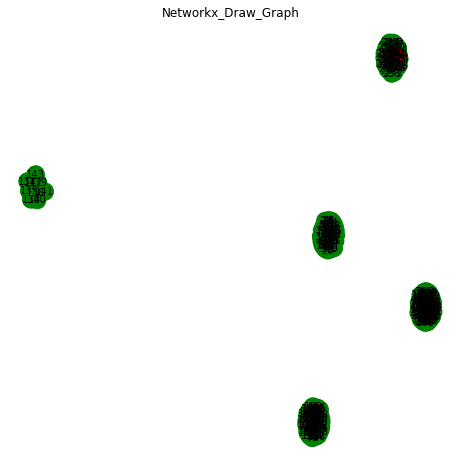

In [ ]:
#### Input Graph
draw_graph_from_nodelist(edge_index.tolist(), [1 for i in range(input_graph_size)])

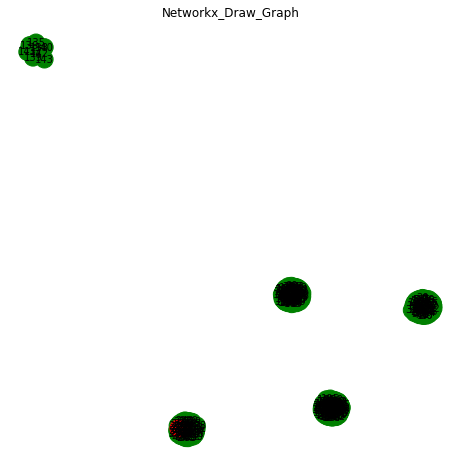

In [ ]:
#### Output Graph (Predictions)
draw_graph_from_nodelist(final_edge_index.tolist(), 
                         [1 for i in range(input_graph_size)])

We print a list of the predicted edges.

In [ ]:
output_edge_list = final_edge_index.tolist()
print(output_edge_list)

[[0, 0], [0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [0, 6], [0, 7], [0, 8], [0, 9], [0, 10], [0, 11], [0, 12], [0, 13], [0, 14], [0, 15], [0, 16], [0, 17], [0, 18], [0, 19], [0, 20], [0, 21], [0, 22], [0, 23], [0, 24], [0, 25], [0, 26], [0, 27], [0, 28], [0, 29], [0, 30], [0, 31], [0, 32], [0, 33], [0, 34], [0, 35], [0, 36], [0, 37], [0, 38], [0, 39], [0, 40], [0, 41], [0, 42], [0, 43], [0, 44], [0, 45], [0, 46], [0, 47], [0, 48], [0, 49], [0, 50], [0, 51], [0, 52], [0, 53], [0, 54], [0, 55], [0, 56], [0, 57], [0, 58], [1, 0], [1, 1], [1, 2], [1, 3], [1, 4], [1, 5], [1, 6], [1, 7], [1, 8], [1, 9], [1, 10], [1, 11], [1, 12], [1, 13], [1, 14], [1, 15], [1, 16], [1, 17], [1, 18], [1, 19], [1, 20], [1, 21], [1, 22], [1, 23], [1, 24], [1, 25], [1, 26], [1, 27], [1, 28], [1, 29], [1, 30], [1, 31], [1, 32], [1, 33], [1, 34], [1, 35], [1, 36], [1, 37], [1, 38], [1, 39], [1, 40], [1, 41], [1, 42], [1, 43], [1, 44], [1, 45], [1, 46], [1, 47], [1, 48], [1, 49], [1, 50], [1, 51], [1, 52], [1, 53], [1

**Compute accuracy of class prediction for train set**

In [ ]:
############### Definition of Class selector Function #######################

def class_selector(node_i, out_edges, probs,class_instances):
  with open('/content/drive/MyDrive/TFG/Input models/map_datasets_train.json') as f:
    map_datasets_train = json.load(f)

  probs_1 = [0]
  probs_2 = [0]
  probs_3 = [0]
  probs_4 = [0]
  probs_5 = [0]

  levels = [0.9, 0.8, 0.7, 0.6, 0.5]

  counter_edges_class = np.zeros(5)
  counter_class_weight = np.zeros(5)

  for node in out_edges:
    if(node < 255):
      if(map_datasets_train[str(node)][0] == '1'):
        counter_edges_class[0] = counter_edges_class[0] + 1
        probs_1.append(probs[node_i][node].item())
      if(map_datasets_train[str(node)][0] == '2'):
        counter_edges_class[1] = counter_edges_class[1] + 1
        probs_2.append(probs[node_i][node].item())
      if(map_datasets_train[str(node)][0] == '3'):
        counter_edges_class[2] = counter_edges_class[2] + 1
        probs_3.append(probs[node_i][node].item())
      if(map_datasets_train[str(node)][0] == '4'):
        counter_edges_class[3] = counter_edges_class[3] + 1
        probs_4.append(probs[node_i][node].item())
      if(map_datasets_train[str(node)][0] == '5'):
        counter_edges_class[4] = counter_edges_class[4] + 1
        probs_5.append(probs[node_i][node].item())

  counter_probs = [np.mean(probs_1),np.mean(probs_2),np.mean(probs_3),np.mean(probs_4),np.mean(probs_5)]
  counter_probs = [0 if x != x else x for x in counter_probs]

  iter = 0
  for level in levels:
    probs_1_aux = []
    probs_2_aux = []
    probs_3_aux = []
    probs_4_aux = []
    probs_5_aux = []  
    
    for prob in probs_1:
      if (prob >= level):
        counter_class_weight[0] += (1-iter/5)*prob
      else:
        probs_1_aux.append(prob)
    for prob in probs_2:
      if (prob >= level):
        counter_class_weight[1] += (1-iter/5)*prob
      else:
        probs_2_aux.append(prob)
    for prob in probs_3:
      if (prob >= level):
        counter_class_weight[2] += (1-iter/5)*prob
      else:
        probs_3_aux.append(prob)
    for prob in probs_4:
      if (prob >= level):
        counter_class_weight[3] += (1-iter/5)*prob
      else:
        probs_4_aux.append(prob)
    for prob in probs_5:
      if (prob >= level):
        counter_class_weight[4] += (1-iter/5)*prob
      else:
        probs_5_aux.append(prob)
    probs_1 = probs_1_aux
    probs_2 = probs_2_aux
    probs_3 = probs_3_aux
    probs_4 = probs_4_aux
    probs_5 = probs_5_aux
    iter += 1
  
  counter_class_weight_norm = counter_class_weight/class_instances
  selector_class = np.argmax(counter_class_weight_norm)+1

  print("Counter edges per class: ", counter_edges_class)
  print("Mean probabilities per class: ",counter_probs)

  print("Weights per class: ",counter_class_weight_norm)
  #print("Class prediction: ", prediction_class)
  return selector_class
  

In [ ]:
z = model_pre_train.encode()
final_edge_index = model_pre_train.decode_all(z)
final_edge_index = final_edge_index.permute(1,0).unsqueeze(1)
final_edge_index = final_edge_index.squeeze(1)

probs_train = model_pre_train.obtain_probs(z)
print(probs_train)

tensor([[1.0000e+00, 1.0000e+00, 1.0000e+00,  ..., 4.4054e-29, 9.1363e-28,
         1.4811e-28],
        [1.0000e+00, 1.0000e+00, 1.0000e+00,  ..., 4.4054e-29, 9.1363e-28,
         1.4811e-28],
        [1.0000e+00, 1.0000e+00, 1.0000e+00,  ..., 4.4054e-29, 9.1363e-28,
         1.4811e-28],
        ...,
        [4.4054e-29, 4.4054e-29, 4.4054e-29,  ..., 1.0000e+00, 1.0000e+00,
         1.0000e+00],
        [9.1363e-28, 9.1363e-28, 9.1363e-28,  ..., 1.0000e+00, 1.0000e+00,
         1.0000e+00],
        [1.4811e-28, 1.4811e-28, 1.4811e-28,  ..., 1.0000e+00, 1.0000e+00,
         1.0000e+00]], grad_fn=<MmBackward>)


In [ ]:
############### Train accuracy ##################
with open('/content/drive/MyDrive/TFG/Input models/map_datasets_train.json') as f:
    map_datasets_train = json.load(f)

accuracy_train = 0
y_train_predicted = []
y_train_true_class = []

class_instances_train = np.zeros(5)
for i in range(0,len(profiles)):
  idx = int(map_datasets_train[str(i)][0]) - 1
  class_instances_train[idx] += 1

for idx_node_train in range(0,len(profiles)):
  print("###################################################")
  print(idx_node_train)
  out_edges = []
  in_edges = []
  for edge in final_edge_index:
      if edge[0] == idx_node_train:
        out_edges.append(edge[1].item())
      if edge[1] == idx_node_train and edge[0] != idx_node_train:
        in_edges.append(edge[0].item())
  class_predicted = class_selector(idx_node_train, out_edges, probs_train, class_instances_train)

  y_train_predicted.append(class_predicted)
  y_train_true_class.append(map_datasets_train[str(idx_node_train)][0])

  print("Class predicted: ", class_predicted)
  print("Real class: ", map_datasets_train[str(idx_node_train)][0])
  
  if(int(map_datasets_train[str(idx_node_train)][0]) == int(class_predicted)):
    accuracy_train += 1

accuracy_train = accuracy_train / len(profiles)

print("***********************************************************")
print("The train accuracy is: ",accuracy_train)

###################################################
0
Counter edges per class:  [59.  0.  0.  0.  0.]
Mean probabilities per class:  [0.9833333333333333, 0.0, 0.0, 0.0, 0.0]
Weights per class:  [1. 0. 0. 0. 0.]
Class predicted:  1
Real class:  1
###################################################
1
Counter edges per class:  [59.  0.  0.  0.  0.]
Mean probabilities per class:  [0.9833333333333333, 0.0, 0.0, 0.0, 0.0]
Weights per class:  [1. 0. 0. 0. 0.]
Class predicted:  1
Real class:  1
###################################################
2
Counter edges per class:  [59.  0.  0.  0.  0.]
Mean probabilities per class:  [0.9833333333333333, 0.0, 0.0, 0.0, 0.0]
Weights per class:  [1. 0. 0. 0. 0.]
Class predicted:  1
Real class:  1
###################################################
3
Counter edges per class:  [59.  0.  0.  0.  0.]
Mean probabilities per class:  [0.9833333333333333, 0.0, 0.0, 0.0, 0.0]
Weights per class:  [1. 0. 0. 0. 0.]
Class predicted:  1
Real class:  1
################

**STEP 6: Model with test data**

---



In [ ]:
##### Load test data ######

profiles_new = pd.read_csv("/content/drive/MyDrive/TFG/Input models/agg_profiles_test.csv")
profiles_new.replace([np.inf, -np.inf], 2**30, inplace=True)
profiles_new.drop("class", axis=1, inplace=True)
profiles_new = profiles_new.fillna(0)
profiles_new = profiles_new.values
profiles_new = scaler.transform(profiles_new).tolist()

with open('/content/drive/MyDrive/TFG/Input models/map_datasets_test.json') as f:
    map_datasets_test = json.load(f)

##############################################################
0


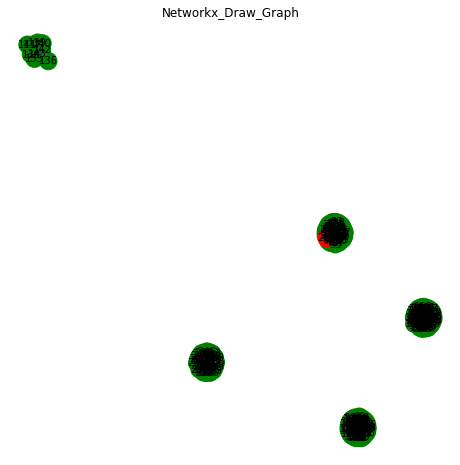

Counter edges per class:  [59.  0.  0.  0.  0.]
Mean probabilities per class:  [0.9833333333333333, 0.0, 0.0, 0.0, 0.0]
Weights per class:  [0.98333333 0.         0.         0.         0.        ]
Class predicted:  1
Real class:  1
##############################################################
1


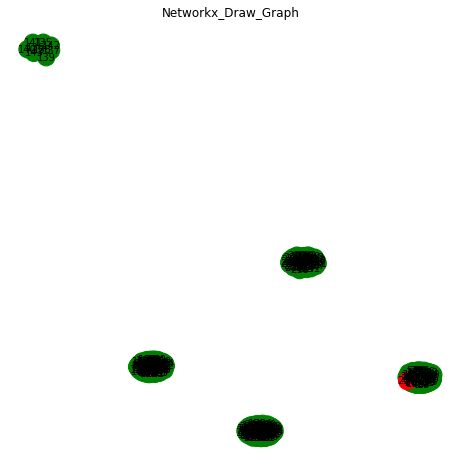

Counter edges per class:  [59.  0.  0.  0.  0.]
Mean probabilities per class:  [0.9833333333333333, 0.0, 0.0, 0.0, 0.0]
Weights per class:  [0.98333333 0.         0.         0.         0.        ]
Class predicted:  1
Real class:  1
##############################################################
2


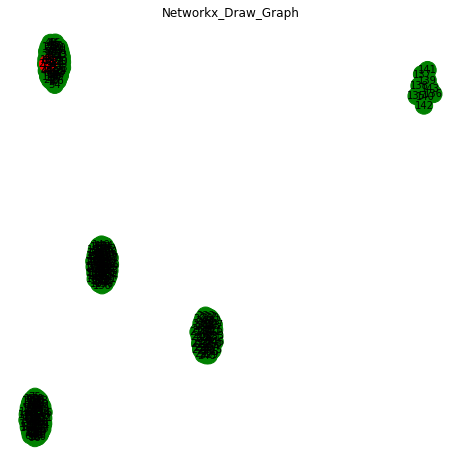

Counter edges per class:  [59.  0.  0.  0.  0.]
Mean probabilities per class:  [0.9833333333333333, 0.0, 0.0, 0.0, 0.0]
Weights per class:  [0.98333333 0.         0.         0.         0.        ]
Class predicted:  1
Real class:  1
##############################################################
3


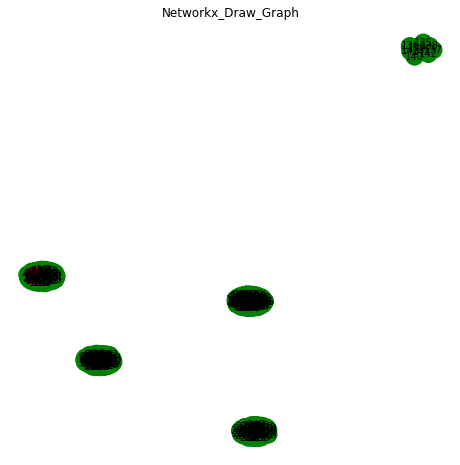

Counter edges per class:  [59.  0.  0.  0.  0.]
Mean probabilities per class:  [0.9833333333333333, 0.0, 0.0, 0.0, 0.0]
Weights per class:  [0.98333333 0.         0.         0.         0.        ]
Class predicted:  1
Real class:  1
##############################################################
4


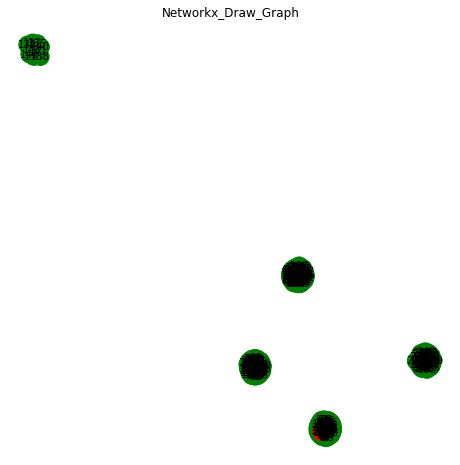

Counter edges per class:  [59.  0.  0.  0.  0.]
Mean probabilities per class:  [0.9833333333333333, 0.0, 0.0, 0.0, 0.0]
Weights per class:  [0.98333333 0.         0.         0.         0.        ]
Class predicted:  1
Real class:  1
##############################################################
5


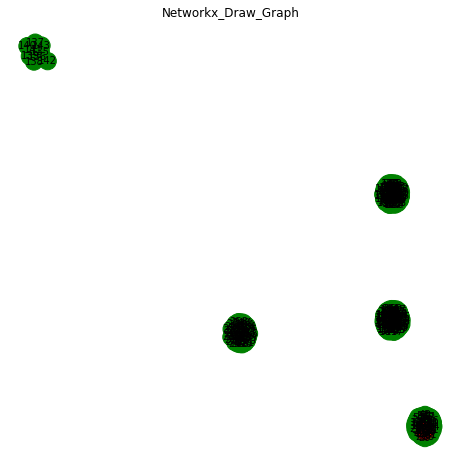

Counter edges per class:  [59.  0.  0.  0.  0.]
Mean probabilities per class:  [0.9833333333333333, 0.0, 0.0, 0.0, 0.0]
Weights per class:  [0.98333333 0.         0.         0.         0.        ]
Class predicted:  1
Real class:  1
##############################################################
6


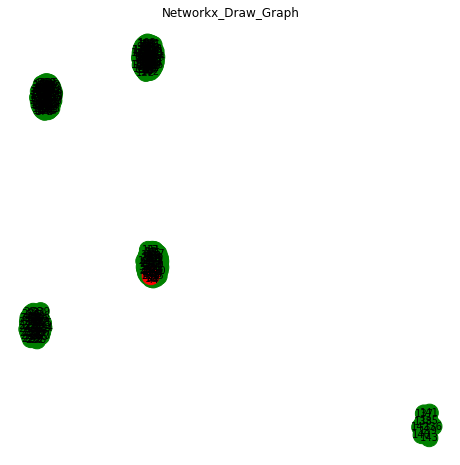

Counter edges per class:  [59.  0.  0.  0.  0.]
Mean probabilities per class:  [0.9833333333333333, 0.0, 0.0, 0.0, 0.0]
Weights per class:  [0.98333333 0.         0.         0.         0.        ]
Class predicted:  1
Real class:  1
##############################################################
7


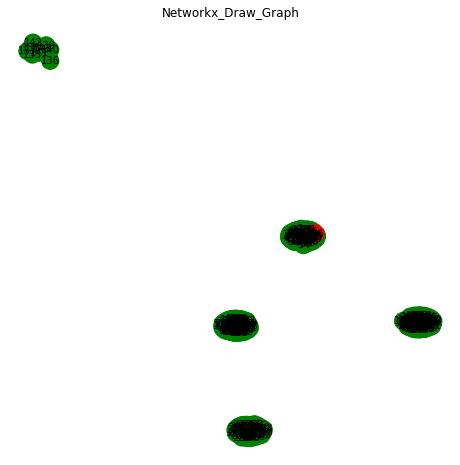

Counter edges per class:  [59.  0.  0.  0.  0.]
Mean probabilities per class:  [0.9833333333333333, 0.0, 0.0, 0.0, 0.0]
Weights per class:  [0.98333333 0.         0.         0.         0.        ]
Class predicted:  1
Real class:  1
##############################################################
8


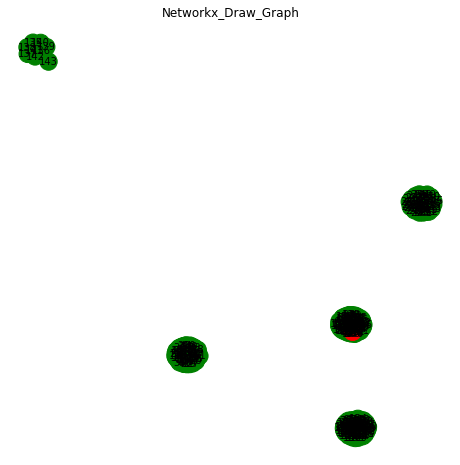

Counter edges per class:  [ 0. 76.  0.  0.  0.]
Mean probabilities per class:  [0.0, 0.987012987012987, 0.0, 0.0, 0.0]
Weights per class:  [0. 1. 0. 0. 0.]
Class predicted:  2
Real class:  1
##############################################################
9


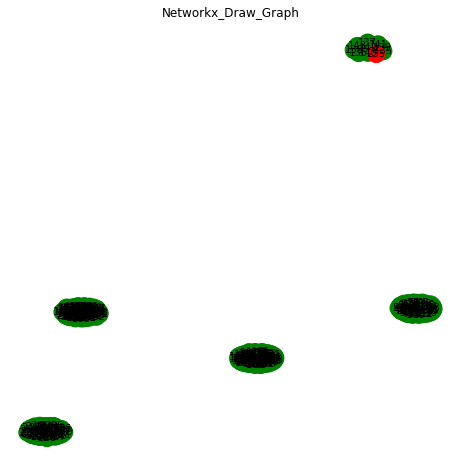

Counter edges per class:  [0. 0. 9. 0. 0.]
Mean probabilities per class:  [0.0, 0.0, 0.9, 0.0, 0.0]
Weights per class:  [0. 0. 1. 0. 0.]
Class predicted:  3
Real class:  1
##############################################################
10


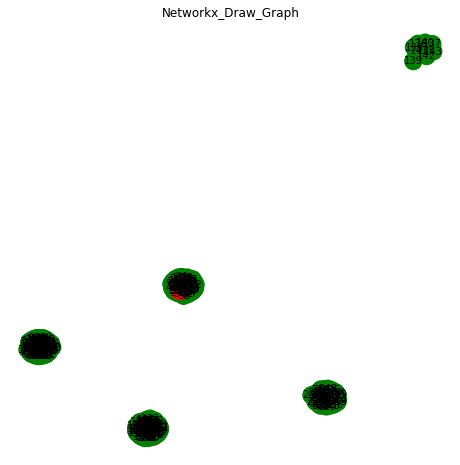

Counter edges per class:  [59.  0.  0.  0.  0.]
Mean probabilities per class:  [0.7410398840904235, 0.0, 0.0, 0.0, 0.0]
Weights per class:  [0.44462393 0.         0.         0.         0.        ]
Class predicted:  1
Real class:  1
##############################################################
11


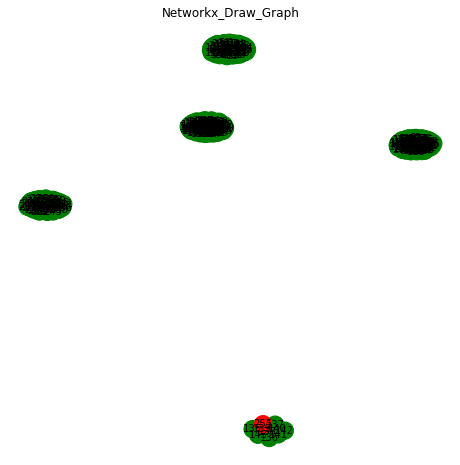

Counter edges per class:  [0. 0. 9. 0. 0.]
Mean probabilities per class:  [0.0, 0.0, 0.9, 0.0, 0.0]
Weights per class:  [0. 0. 1. 0. 0.]
Class predicted:  3
Real class:  1
##############################################################
12


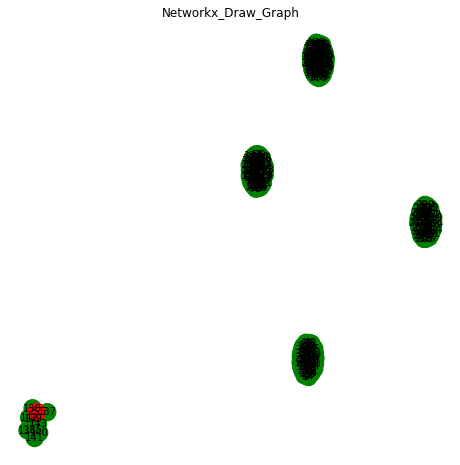

Counter edges per class:  [0. 0. 9. 0. 0.]
Mean probabilities per class:  [0.0, 0.0, 0.8999998927116394, 0.0, 0.0]
Weights per class:  [0.         0.         0.99999988 0.         0.        ]
Class predicted:  3
Real class:  1
##############################################################
13


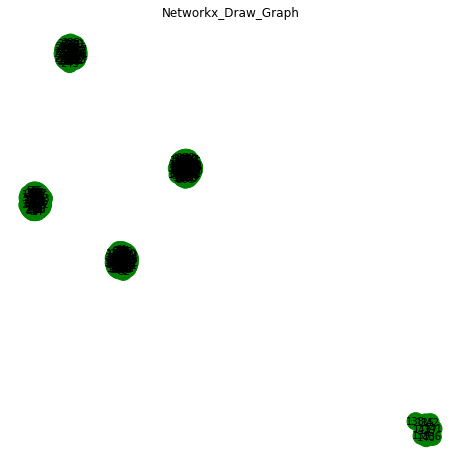

Counter edges per class:  [ 0.  0.  0. 70.  0.]
Mean probabilities per class:  [0.0, 0.0, 0.0, 0.9859154929577465, 0.0]
Weights per class:  [0. 0. 0. 1. 0.]
Class predicted:  4
Real class:  1
##############################################################
14


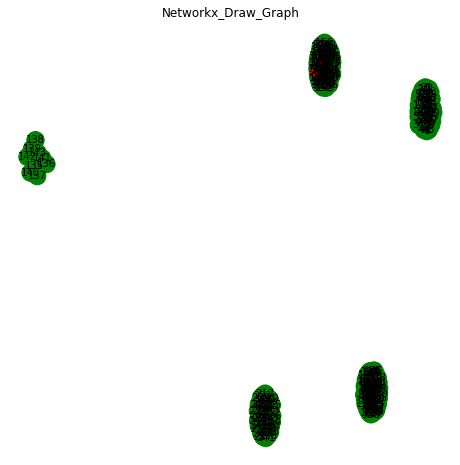

Counter edges per class:  [ 0.  0.  0. 70.  0.]
Mean probabilities per class:  [0.0, 0.0, 0.0, 0.9859154929577465, 0.0]
Weights per class:  [0. 0. 0. 1. 0.]
Class predicted:  4
Real class:  1
##############################################################
15


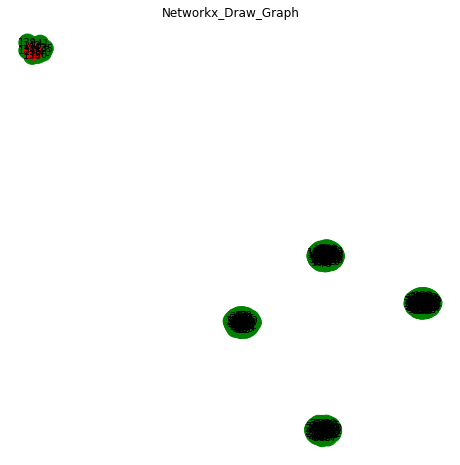

Counter edges per class:  [0. 0. 9. 0. 0.]
Mean probabilities per class:  [0.0, 0.0, 0.9, 0.0, 0.0]
Weights per class:  [0. 0. 1. 0. 0.]
Class predicted:  3
Real class:  2
##############################################################
16


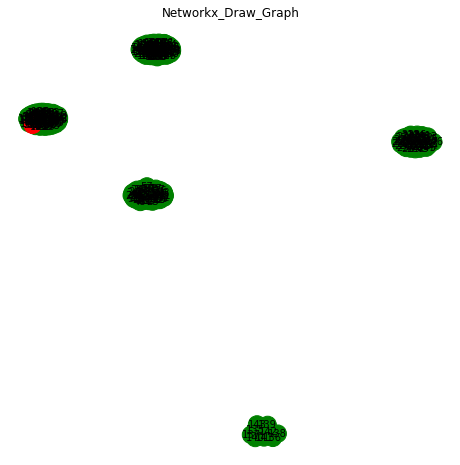

Counter edges per class:  [ 0. 76.  0.  0.  0.]
Mean probabilities per class:  [0.0, 0.987012987012987, 0.0, 0.0, 0.0]
Weights per class:  [0.         0.98701299 0.         0.         0.        ]
Class predicted:  2
Real class:  2
##############################################################
17


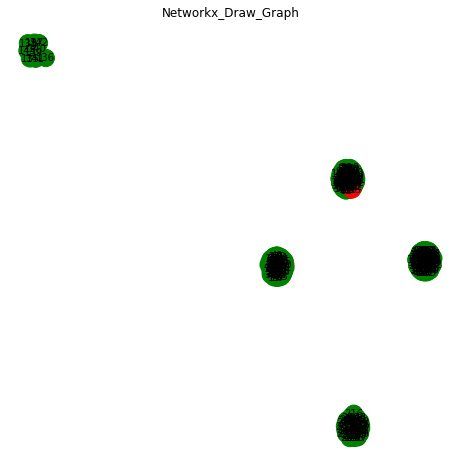

Counter edges per class:  [ 0. 76.  0.  0.  0.]
Mean probabilities per class:  [0.0, 0.987012987012987, 0.0, 0.0, 0.0]
Weights per class:  [0.         0.98701299 0.         0.         0.        ]
Class predicted:  2
Real class:  2
##############################################################
18


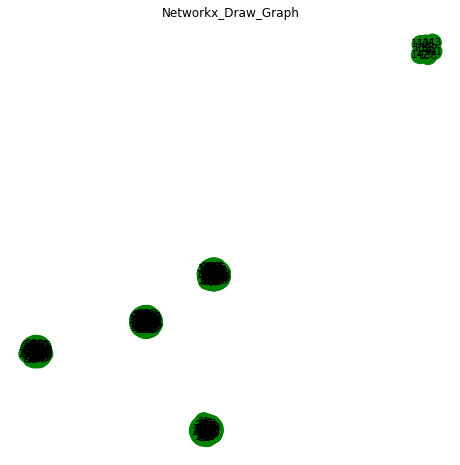

Counter edges per class:  [ 0. 76.  0.  0.  0.]
Mean probabilities per class:  [0.0, 0.987012987012987, 0.0, 0.0, 0.0]
Weights per class:  [0.         0.98701299 0.         0.         0.        ]
Class predicted:  2
Real class:  2
##############################################################
19


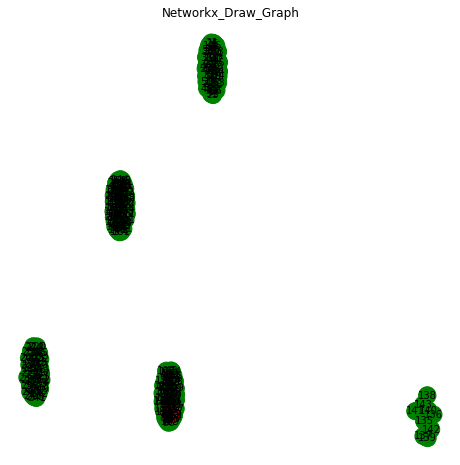

Counter edges per class:  [ 0. 76.  0.  0.  0.]
Mean probabilities per class:  [0.0, 0.987012987012987, 0.0, 0.0, 0.0]
Weights per class:  [0.         0.98701299 0.         0.         0.        ]
Class predicted:  2
Real class:  2
##############################################################
20


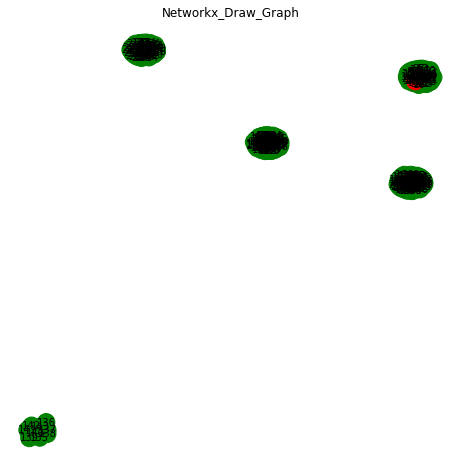

Counter edges per class:  [59.  0.  0.  0.  0.]
Mean probabilities per class:  [0.9331563144922257, 0.0, 0.0, 0.0, 0.0]
Weights per class:  [0.94897252 0.         0.         0.         0.        ]
Class predicted:  1
Real class:  2
##############################################################
21


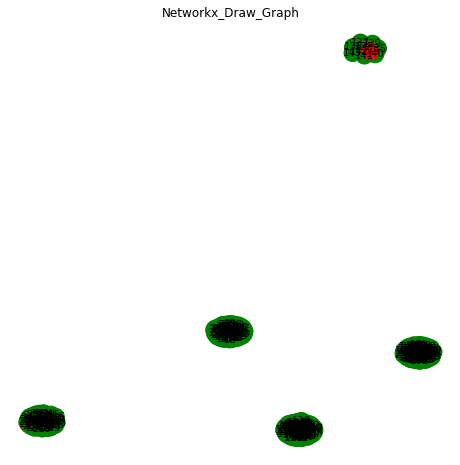

Counter edges per class:  [0. 0. 9. 0. 0.]
Mean probabilities per class:  [0.0, 0.0, 0.7671713769435883, 0.0, 0.0]
Weights per class:  [0.         0.         0.68193011 0.         0.        ]
Class predicted:  3
Real class:  2
##############################################################
22


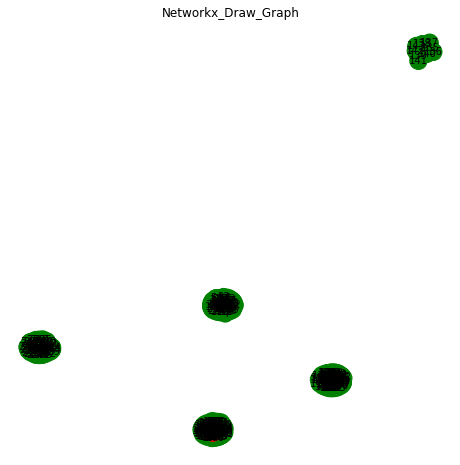

Counter edges per class:  [ 0.  0.  0. 70.  0.]
Mean probabilities per class:  [0.0, 0.0, 0.0, 0.9859154929577465, 0.0]
Weights per class:  [0. 0. 0. 1. 0.]
Class predicted:  4
Real class:  2
##############################################################
23


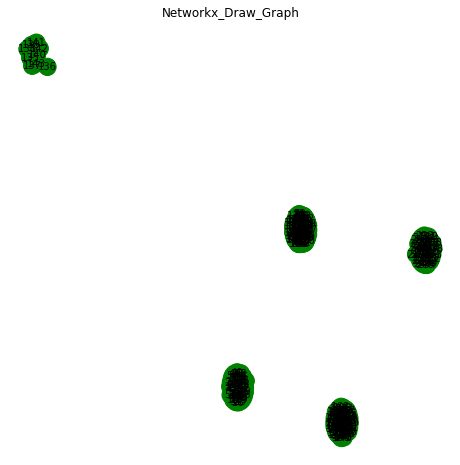

Counter edges per class:  [ 0. 76.  0.  0.  0.]
Mean probabilities per class:  [0.0, 0.987012987012987, 0.0, 0.0, 0.0]
Weights per class:  [0.         0.98701299 0.         0.         0.        ]
Class predicted:  2
Real class:  2
##############################################################
24


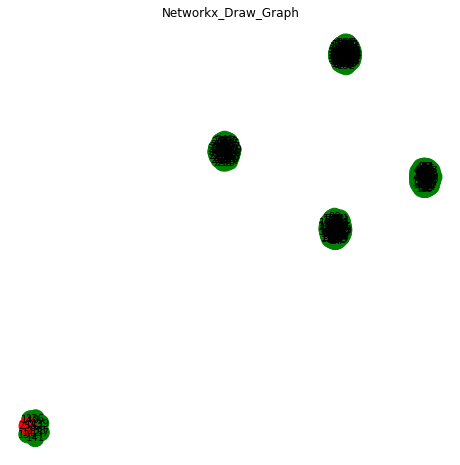

Counter edges per class:  [0. 0. 9. 0. 0.]
Mean probabilities per class:  [0.0, 0.0, 0.9, 0.0, 0.0]
Weights per class:  [0. 0. 1. 0. 0.]
Class predicted:  3
Real class:  2
##############################################################
25


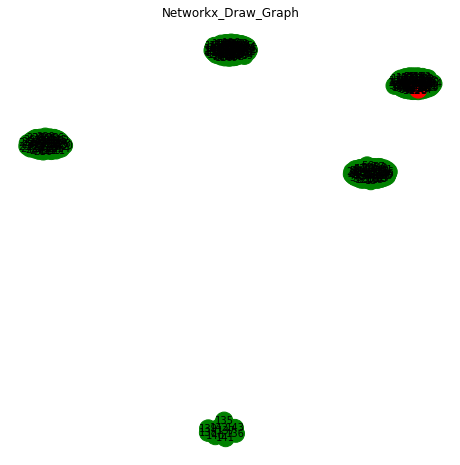

Counter edges per class:  [ 0. 76.  0.  0.  0.]
Mean probabilities per class:  [0.0, 0.987012987012987, 0.0, 0.0, 0.0]
Weights per class:  [0.         0.98701299 0.         0.         0.        ]
Class predicted:  2
Real class:  2
##############################################################
26


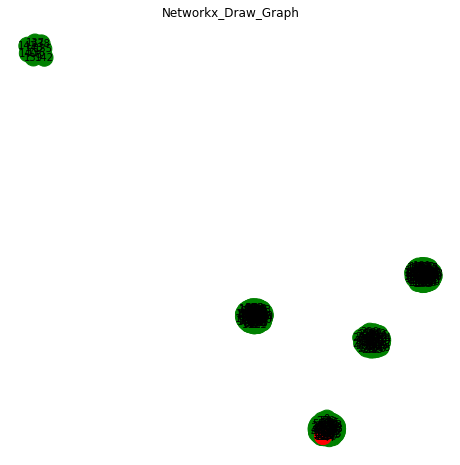

Counter edges per class:  [59.  0.  0.  0.  0.]
Mean probabilities per class:  [0.9833333333333333, 0.0, 0.0, 0.0, 0.0]
Weights per class:  [1. 0. 0. 0. 0.]
Class predicted:  1
Real class:  2
##############################################################
27


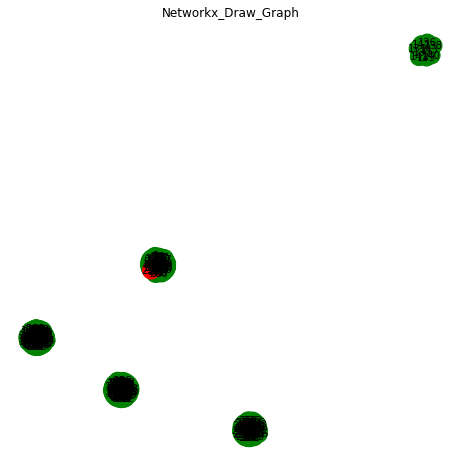

Counter edges per class:  [59.  0.  0.  0.  0.]
Mean probabilities per class:  [0.9833333333333333, 0.0, 0.0, 0.0, 0.0]
Weights per class:  [1. 0. 0. 0. 0.]
Class predicted:  1
Real class:  2
##############################################################
28


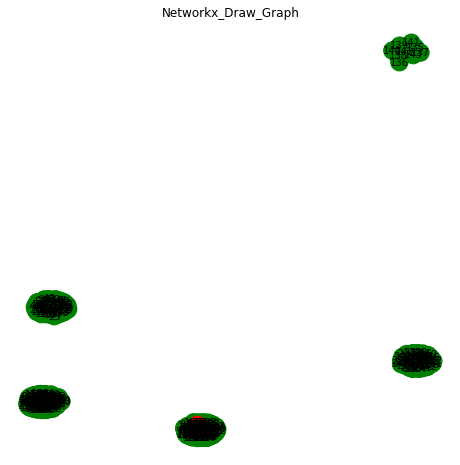

Counter edges per class:  [ 0. 76.  0.  0.  0.]
Mean probabilities per class:  [0.0, 0.987012987012987, 0.0, 0.0, 0.0]
Weights per class:  [0.         0.98701299 0.         0.         0.        ]
Class predicted:  2
Real class:  2
##############################################################
29


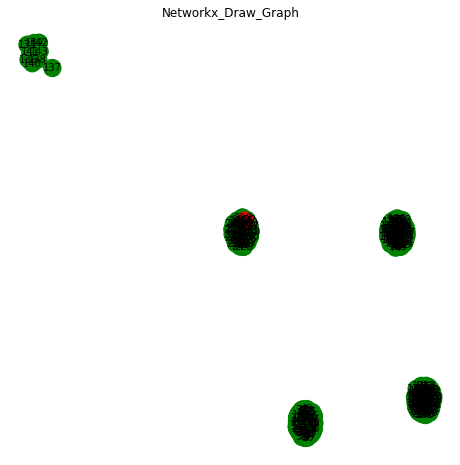

Counter edges per class:  [ 0.  0.  0.  0. 41.]
Mean probabilities per class:  [0.0, 0.0, 0.0, 0.0, 0.9761904761904762]
Weights per class:  [0. 0. 0. 0. 1.]
Class predicted:  5
Real class:  2
##############################################################
30


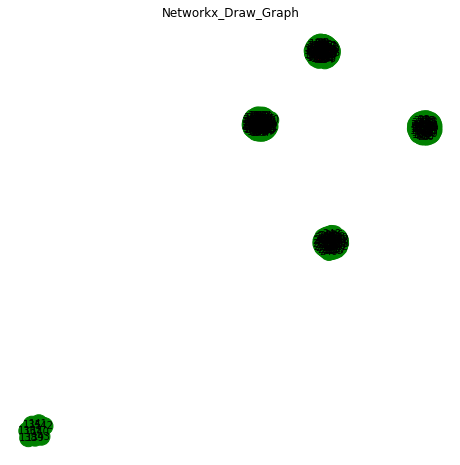

Counter edges per class:  [ 0. 76.  0.  0.  0.]
Mean probabilities per class:  [0.0, 0.9825125669504141, 0.0, 0.0, 0.0]
Weights per class:  [0.         0.98251257 0.         0.         0.        ]
Class predicted:  2
Real class:  2
##############################################################
31


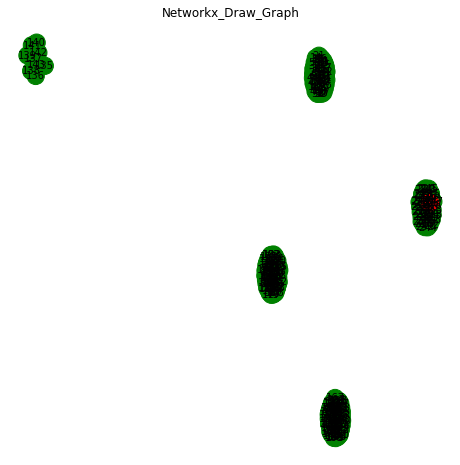

Counter edges per class:  [ 0.  0.  0.  0. 41.]
Mean probabilities per class:  [0.0, 0.0, 0.0, 0.0, 0.9761904761904762]
Weights per class:  [0. 0. 0. 0. 1.]
Class predicted:  5
Real class:  2
##############################################################
32


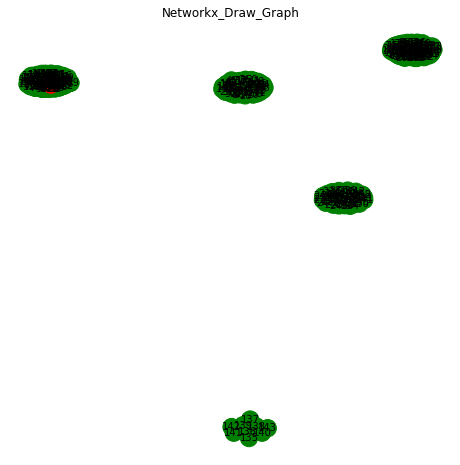

Counter edges per class:  [ 0. 76.  0.  0.  0.]
Mean probabilities per class:  [0.0, 0.987012987012987, 0.0, 0.0, 0.0]
Weights per class:  [0.         0.98701299 0.         0.         0.        ]
Class predicted:  2
Real class:  2
##############################################################
33


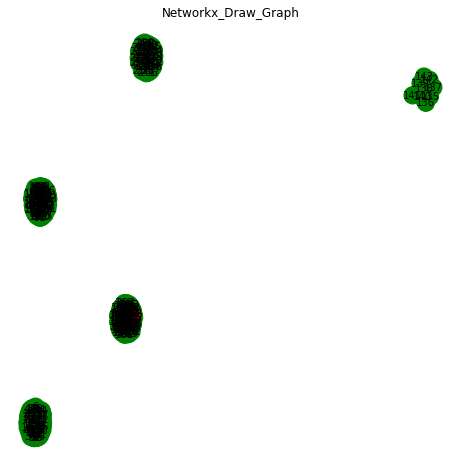

Counter edges per class:  [ 0.  0.  0. 70.  0.]
Mean probabilities per class:  [0.0, 0.0, 0.0, 0.9859154929577465, 0.0]
Weights per class:  [0. 0. 0. 1. 0.]
Class predicted:  4
Real class:  2
##############################################################
34


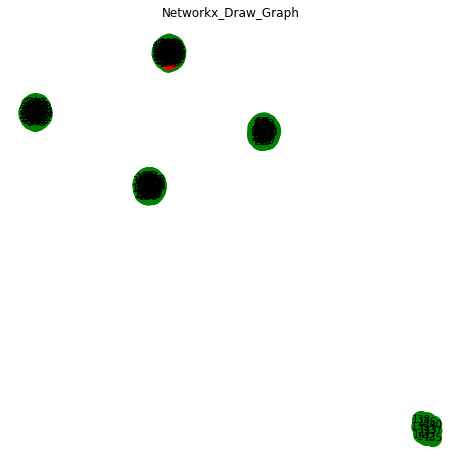

Counter edges per class:  [ 0.  0.  0. 70.  0.]
Mean probabilities per class:  [0.0, 0.0, 0.0, 0.9859154929577465, 0.0]
Weights per class:  [0. 0. 0. 1. 0.]
Class predicted:  4
Real class:  3
##############################################################
35


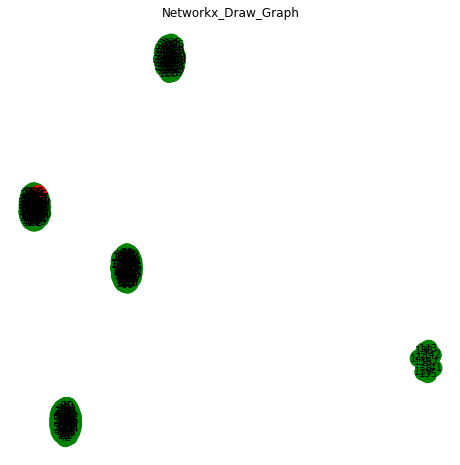

Counter edges per class:  [ 0.  0.  0. 70.  0.]
Mean probabilities per class:  [0.0, 0.0, 0.0, 0.9859154929577465, 0.0]
Weights per class:  [0. 0. 0. 1. 0.]
Class predicted:  4
Real class:  3
##############################################################
36


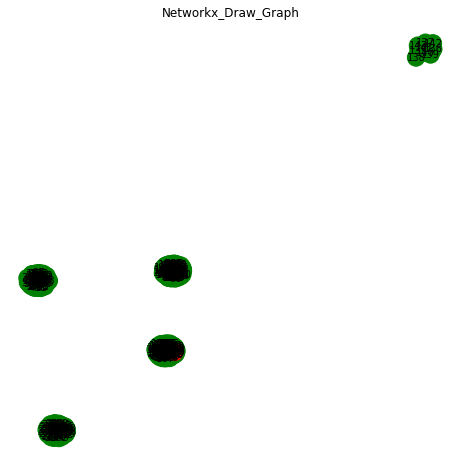

Counter edges per class:  [ 0.  0.  0. 70.  0.]
Mean probabilities per class:  [0.0, 0.0, 0.0, 0.9859145527154627, 0.0]
Weights per class:  [0.         0.         0.         0.98591455 0.        ]
Class predicted:  4
Real class:  4
##############################################################
37


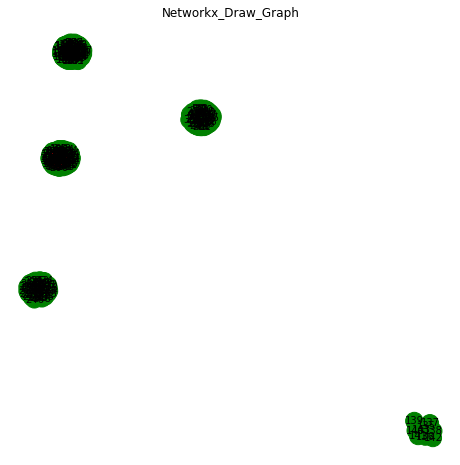

Counter edges per class:  [ 0.  0.  0. 70.  0.]
Mean probabilities per class:  [0.0, 0.0, 0.0, 0.9859154929577465, 0.0]
Weights per class:  [0.         0.         0.         0.98591549 0.        ]
Class predicted:  4
Real class:  4
##############################################################
38


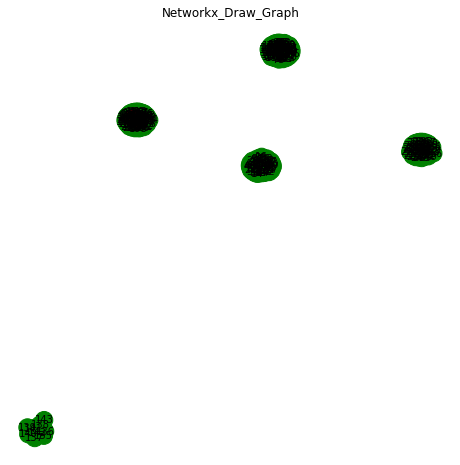

Counter edges per class:  [ 0.  0.  0. 70.  0.]
Mean probabilities per class:  [0.0, 0.0, 0.0, 0.9859154929577465, 0.0]
Weights per class:  [0.         0.         0.         0.98591549 0.        ]
Class predicted:  4
Real class:  4
##############################################################
39


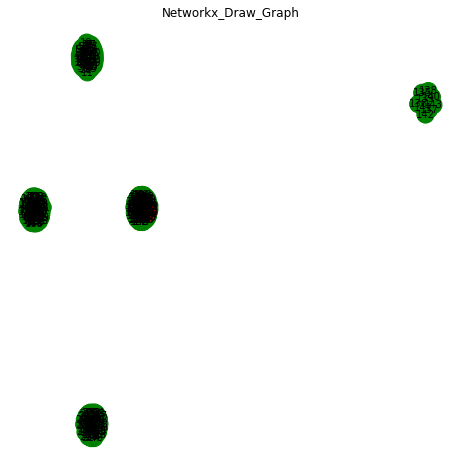

Counter edges per class:  [ 0.  0.  0. 70.  0.]
Mean probabilities per class:  [0.0, 0.0, 0.0, 0.9859154929577465, 0.0]
Weights per class:  [0.         0.         0.         0.98591549 0.        ]
Class predicted:  4
Real class:  4
##############################################################
40


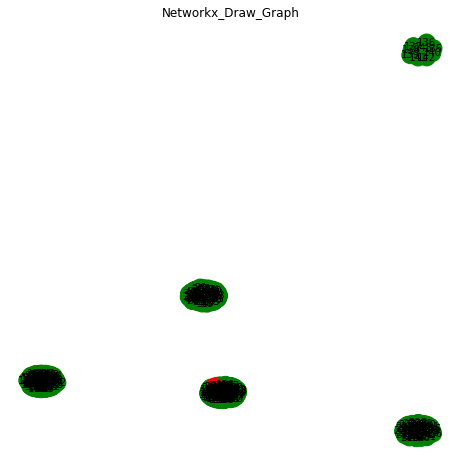

Counter edges per class:  [ 0.  0.  0. 70.  0.]
Mean probabilities per class:  [0.0, 0.0, 0.0, 0.9859154929577465, 0.0]
Weights per class:  [0.         0.         0.         0.98591549 0.        ]
Class predicted:  4
Real class:  4
##############################################################
41


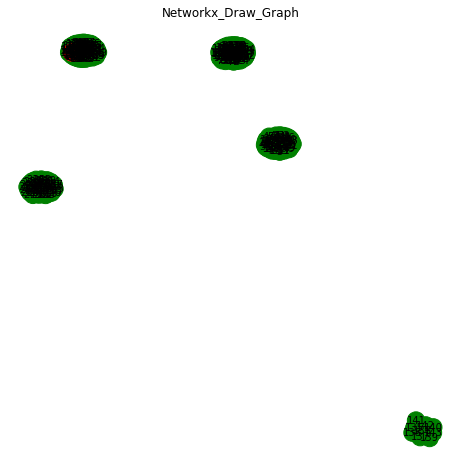

Counter edges per class:  [ 0.  0.  0. 70.  0.]
Mean probabilities per class:  [0.0, 0.0, 0.0, 0.9859154929577465, 0.0]
Weights per class:  [0.         0.         0.         0.98591549 0.        ]
Class predicted:  4
Real class:  4
##############################################################
42


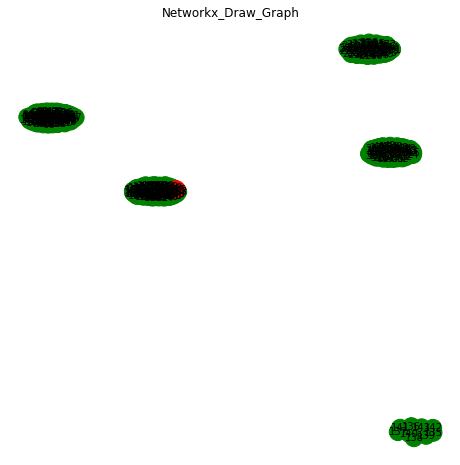

Counter edges per class:  [ 0.  0.  0. 70.  0.]
Mean probabilities per class:  [0.0, 0.0, 0.0, 0.9859154929577465, 0.0]
Weights per class:  [0.         0.         0.         0.98591549 0.        ]
Class predicted:  4
Real class:  4
##############################################################
43


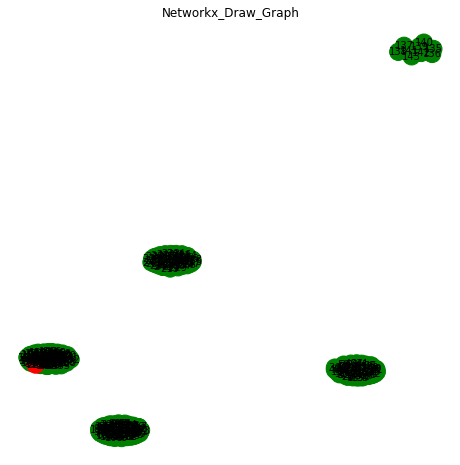

Counter edges per class:  [ 0.  0.  0. 70.  0.]
Mean probabilities per class:  [0.0, 0.0, 0.0, 0.9859154929577465, 0.0]
Weights per class:  [0.         0.         0.         0.98591549 0.        ]
Class predicted:  4
Real class:  4
##############################################################
44


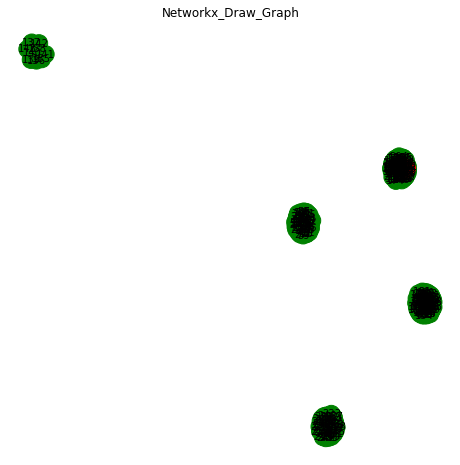

Counter edges per class:  [ 0.  0.  0. 70.  0.]
Mean probabilities per class:  [0.0, 0.0, 0.0, 0.9859142001246063, 0.0]
Weights per class:  [0.        0.        0.        0.9859142 0.       ]
Class predicted:  4
Real class:  4
##############################################################
45


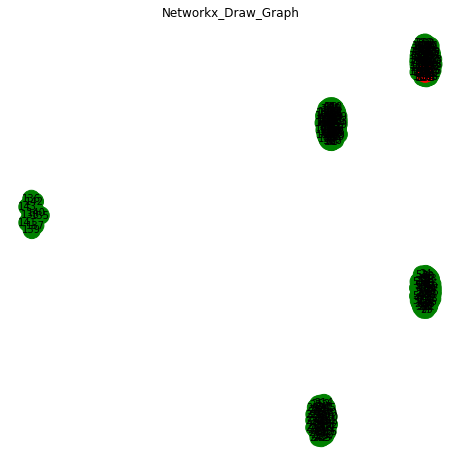

Counter edges per class:  [ 0.  0.  0. 70.  0.]
Mean probabilities per class:  [0.0, 0.0, 0.0, 0.9859154929577465, 0.0]
Weights per class:  [0.         0.         0.         0.98591549 0.        ]
Class predicted:  4
Real class:  4
##############################################################
46


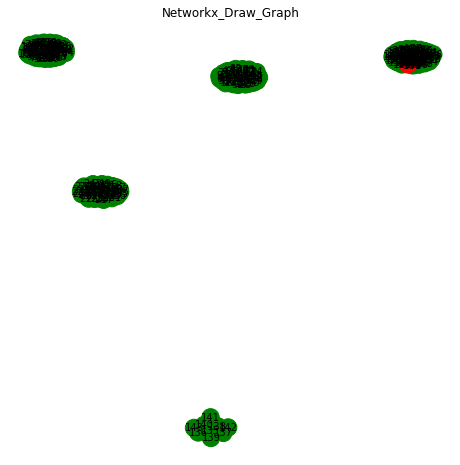

Counter edges per class:  [ 0.  0.  0. 70.  0.]
Mean probabilities per class:  [0.0, 0.0, 0.0, 0.9859154929577465, 0.0]
Weights per class:  [0.         0.         0.         0.98591549 0.        ]
Class predicted:  4
Real class:  4
##############################################################
47


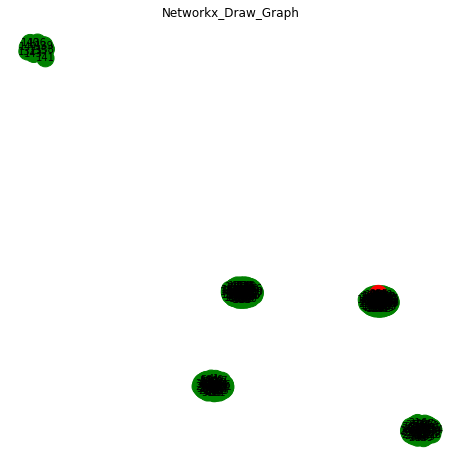

Counter edges per class:  [ 0.  0.  0. 70.  0.]
Mean probabilities per class:  [0.0, 0.0, 0.0, 0.9859154929577465, 0.0]
Weights per class:  [0.         0.         0.         0.98591549 0.        ]
Class predicted:  4
Real class:  4
##############################################################
48


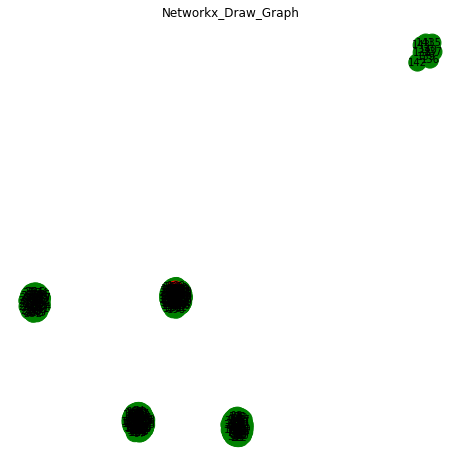

Counter edges per class:  [ 0.  0.  0. 70.  0.]
Mean probabilities per class:  [0.0, 0.0, 0.0, 0.9859154929577465, 0.0]
Weights per class:  [0.         0.         0.         0.98591549 0.        ]
Class predicted:  4
Real class:  4
##############################################################
49


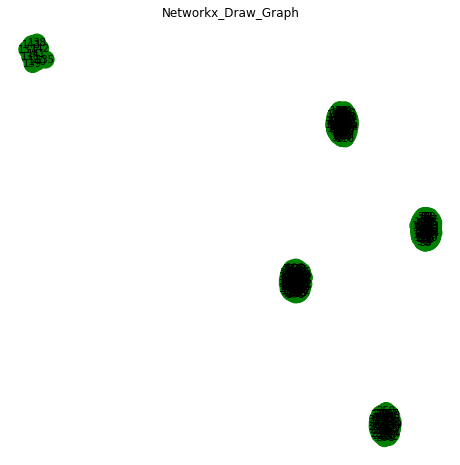

Counter edges per class:  [ 0.  0.  0. 70.  0.]
Mean probabilities per class:  [0.0, 0.0, 0.0, 0.9859154929577465, 0.0]
Weights per class:  [0.         0.         0.         0.98591549 0.        ]
Class predicted:  4
Real class:  4
##############################################################
50


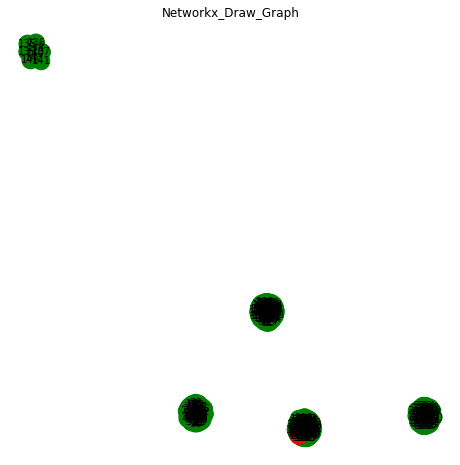

Counter edges per class:  [ 0.  0.  0. 70.  0.]
Mean probabilities per class:  [0.0, 0.0, 0.0, 0.9859154929577465, 0.0]
Weights per class:  [0.         0.         0.         0.98591549 0.        ]
Class predicted:  4
Real class:  4
##############################################################
51


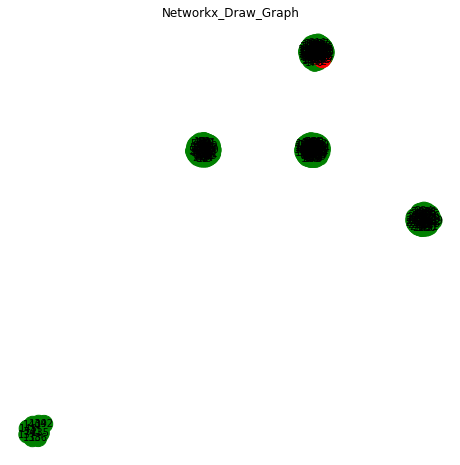

Counter edges per class:  [ 0.  0.  0. 70.  0.]
Mean probabilities per class:  [0.0, 0.0, 0.0, 0.9859154929577465, 0.0]
Weights per class:  [0.         0.         0.         0.98591549 0.        ]
Class predicted:  4
Real class:  4
##############################################################
52


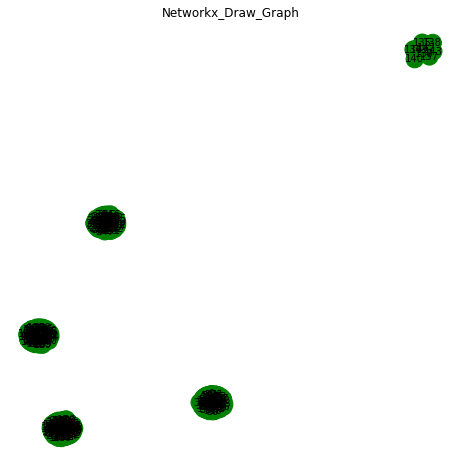

Counter edges per class:  [ 0.  0.  0. 70.  0.]
Mean probabilities per class:  [0.0, 0.0, 0.0, 0.9859154929577465, 0.0]
Weights per class:  [0.         0.         0.         0.98591549 0.        ]
Class predicted:  4
Real class:  4
##############################################################
53


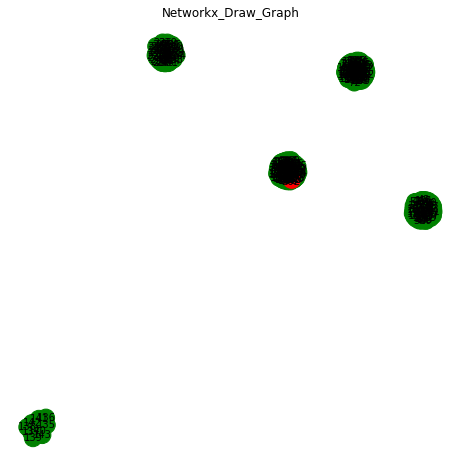

Counter edges per class:  [ 0.  0.  0. 70.  0.]
Mean probabilities per class:  [0.0, 0.0, 0.0, 0.9859154929577465, 0.0]
Weights per class:  [0.         0.         0.         0.98591549 0.        ]
Class predicted:  4
Real class:  4
##############################################################
54


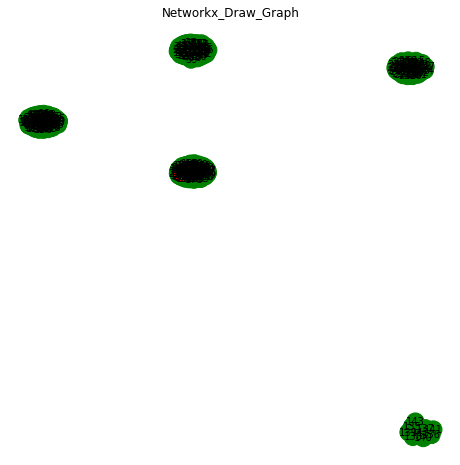

Counter edges per class:  [ 0.  0.  0. 70.  0.]
Mean probabilities per class:  [0.0, 0.0, 0.0, 0.9859154929577465, 0.0]
Weights per class:  [0.         0.         0.         0.98591549 0.        ]
Class predicted:  4
Real class:  4
##############################################################
55


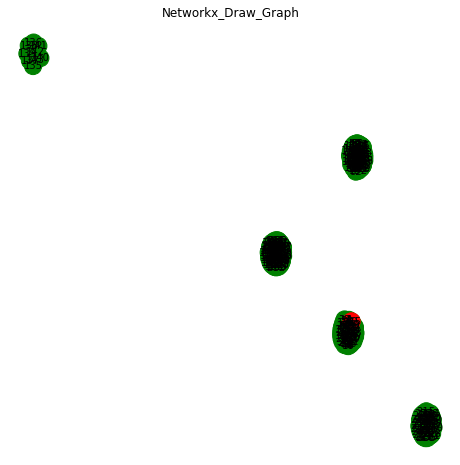

Counter edges per class:  [59.  0.  0.  0.  0.]
Mean probabilities per class:  [0.9833333333333333, 0.0, 0.0, 0.0, 0.0]
Weights per class:  [1. 0. 0. 0. 0.]
Class predicted:  1
Real class:  5
##############################################################
56


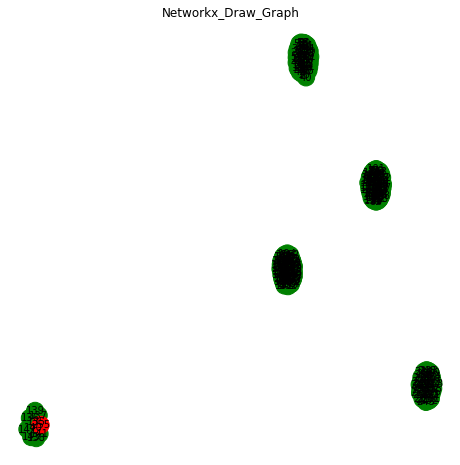

Counter edges per class:  [0. 0. 9. 0. 0.]
Mean probabilities per class:  [0.0, 0.0, 0.8997738897800446, 0.0, 0.0]
Weights per class:  [0.         0.         0.99974877 0.         0.        ]
Class predicted:  3
Real class:  5
##############################################################
57


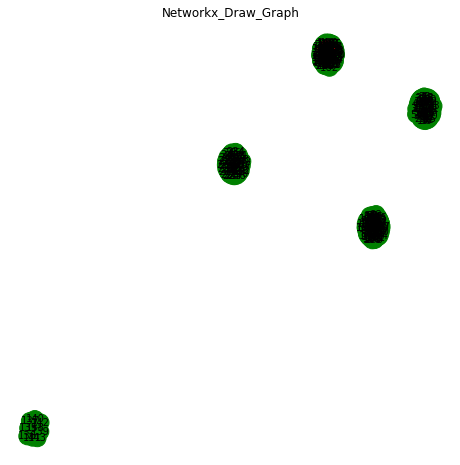

Counter edges per class:  [ 0.  0.  0. 70.  0.]
Mean probabilities per class:  [0.0, 0.0, 0.0, 0.9859154929577465, 0.0]
Weights per class:  [0. 0. 0. 1. 0.]
Class predicted:  4
Real class:  5
##############################################################
58


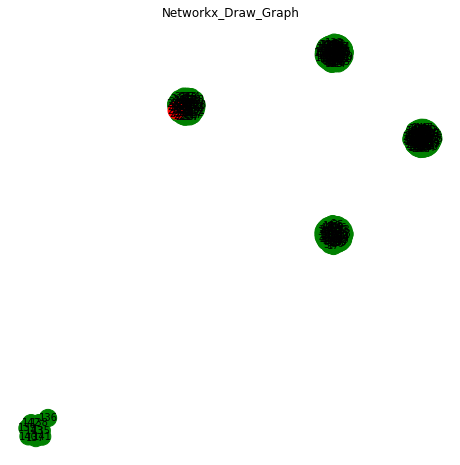

Counter edges per class:  [ 0.  0.  0.  0. 41.]
Mean probabilities per class:  [0.0, 0.0, 0.0, 0.0, 0.9761904761904762]
Weights per class:  [0.         0.         0.         0.         0.97619048]
Class predicted:  5
Real class:  5
##############################################################
59


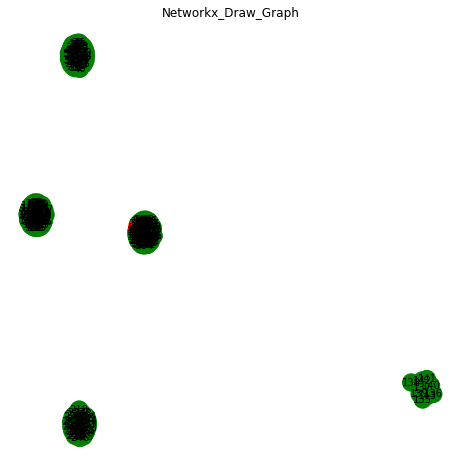

Counter edges per class:  [ 0.  0.  0. 70.  0.]
Mean probabilities per class:  [0.0, 0.0, 0.0, 0.9859152578971755, 0.0]
Weights per class:  [0.         0.         0.         0.99999976 0.        ]
Class predicted:  4
Real class:  5
##############################################################
60


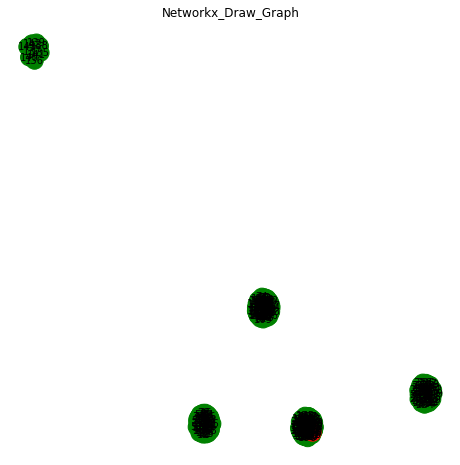

Counter edges per class:  [ 0.  0.  0. 70.  0.]
Mean probabilities per class:  [0.0, 0.0, 0.0, 0.9859084411406182, 0.0]
Weights per class:  [0.         0.         0.         0.99999285 0.        ]
Class predicted:  4
Real class:  5
##############################################################
61


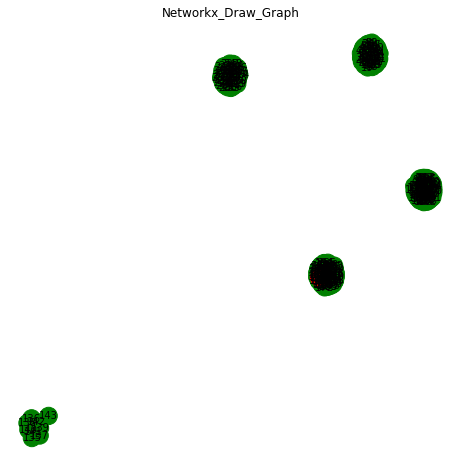

Counter edges per class:  [ 0.  0.  0. 70.  0.]
Mean probabilities per class:  [0.0, 0.0, 0.0, 0.9859154929577465, 0.0]
Weights per class:  [0. 0. 0. 1. 0.]
Class predicted:  4
Real class:  5
##############################################################
62


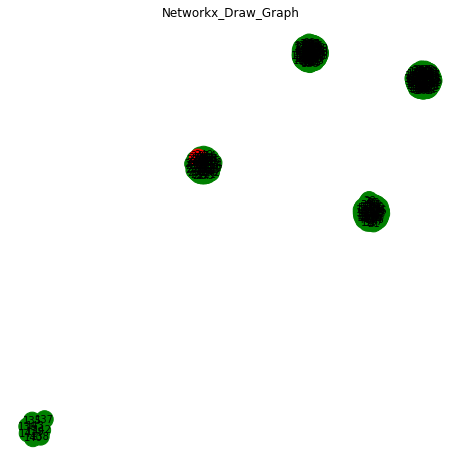

Counter edges per class:  [ 0.  0.  0.  0. 41.]
Mean probabilities per class:  [0.0, 0.0, 0.0, 0.0, 0.9761904761904762]
Weights per class:  [0.         0.         0.         0.         0.97619048]
Class predicted:  5
Real class:  5
##############################################################
63


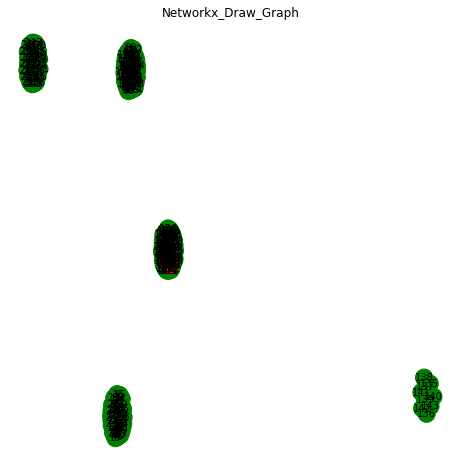

Counter edges per class:  [ 0.  0.  0. 70.  0.]
Mean probabilities per class:  [0.0, 0.0, 0.0, 0.9859154929577465, 0.0]
Weights per class:  [0. 0. 0. 1. 0.]
Class predicted:  4
Real class:  5
***********************************************************
The test accuracy is:  0.609375


In [ ]:
##### Load test data - Mode: node_test NOT linked in input graph ######
accuracy_test = 0
y_test_predicted = []
y_test_true_class = []

for idx_node_test in range (0,len(profiles_new)):

  node_test = len(profiles)
  class_instances_test = class_instances_train.copy()
  class_node = int(map_datasets_test[str(node_test+idx_node_test)][0]) - 1
  class_instances_test[class_node] += 1

  print("##############################################################")
  print(idx_node_test)
  #### Insert test data to train data ####
  node_test = len(profiles)

  list_edges_test = list_edges.copy()
  list_edges_test.append([node_test,node_test])

  edge_index_test = torch.tensor(list_edges_test, dtype=torch.long)

  profiles_test = profiles.copy()
  profiles_test.append(profiles_new[idx_node_test])

  x = torch.tensor(profiles_test, dtype=torch.float)
  data = Data(x=x, edge_index=edge_index_test.t().contiguous())


  ####### Make prediction ###########
  z = model_pre_test.encode()
  probs_test = model_pre_test.obtain_probs(z)
  final_edge_index = model_pre_test.decode_all(z)

  final_edge_index = final_edge_index.permute(1,0).unsqueeze(1)
  final_edge_index = final_edge_index.squeeze(1)

  draw_graph_from_nodelist(final_edge_index.tolist(), [1 for i in range(node_test+1)])

  out_edges = []
  in_edges = []
  for edge in final_edge_index:
      if edge[0] == node_test and edge[1] != node_test:
        out_edges.append(edge[1].item())
      if edge[1] == node_test and edge[0] != node_test:
        in_edges.append(edge[0].item())

  class_predicted = class_selector(node_test, out_edges, probs_test,class_instances_test)
  print("Class predicted: ", class_predicted)
  print("Real class: ", map_datasets_test[str(node_test+idx_node_test)][0])

  y_test_predicted.append(str(class_predicted))
  y_test_true_class.append(map_datasets_test[str(node_test+idx_node_test)][0])

  if(int(map_datasets_test[str(node_test+idx_node_test)][0]) == int(class_predicted)):
    accuracy_test += 1

accuracy_test = accuracy_test / len(profiles_new)

print("***********************************************************")
print("The test accuracy is: ", accuracy_test)

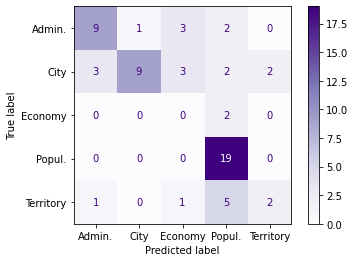

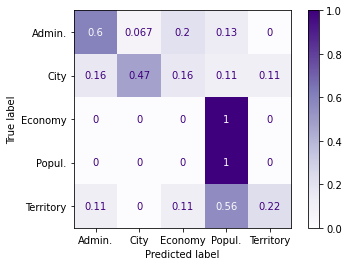

In [ ]:
title = [("GCNN Approach 1 Confusion Matrix", None),
         ("GCNN Approach 1 Normalized Confusion Matrix", 'true')]
class_names = ['Admin.', 'City', 'Economy','Popul.', 'Territory']
for title, normalize in title:
  cm = confusion_matrix(y_test_true_class, y_test_predicted, normalize = normalize)
  cmd = ConfusionMatrixDisplay(cm, display_labels= ['Admin.', 'City', 'Economy','Popul.', 'Territory'])
  cmd.plot(cmap = plt.cm.Purples)

##############################################################
0


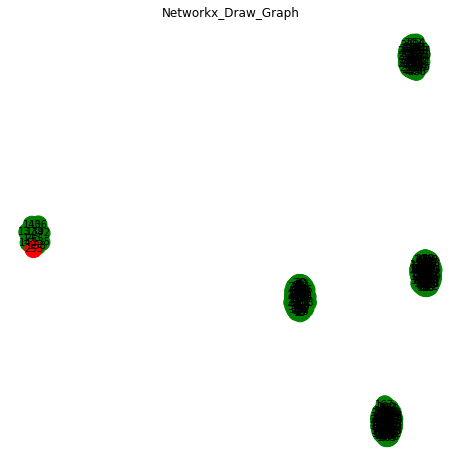

Counter edges per class:  [0. 0. 9. 0. 0.]
Mean probabilities per class:  [0.0, 0.0, 0.8945742666721344, 0.0, 0.0]
Weights per class:  [0.         0.         0.99397141 0.         0.        ]
Class predicted:  3
Real class:  1
##############################################################
1


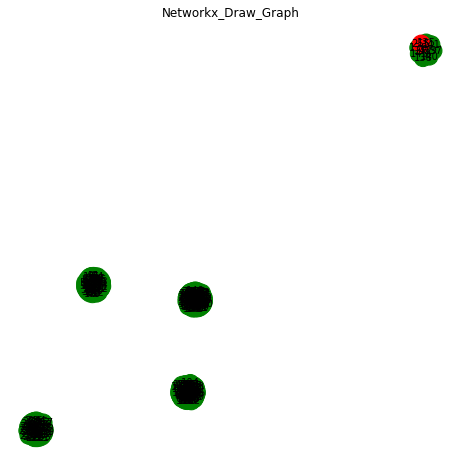

Counter edges per class:  [0. 0. 9. 0. 0.]
Mean probabilities per class:  [0.0, 0.0, 0.892812967300415, 0.0, 0.0]
Weights per class:  [0.         0.         0.99201441 0.         0.        ]
Class predicted:  3
Real class:  1
##############################################################
2


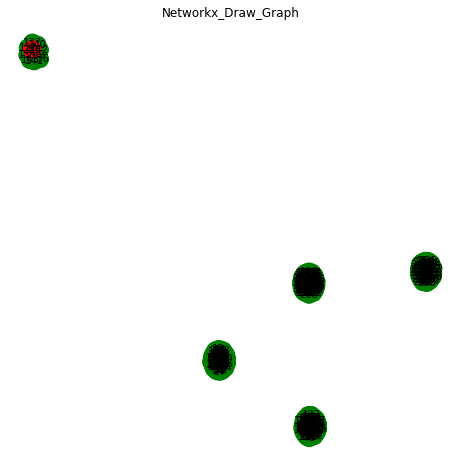

Counter edges per class:  [0. 0. 9. 0. 0.]
Mean probabilities per class:  [0.0, 0.0, 0.8960230886936188, 0.0, 0.0]
Weights per class:  [0.         0.         0.99558121 0.         0.        ]
Class predicted:  3
Real class:  1
##############################################################
3


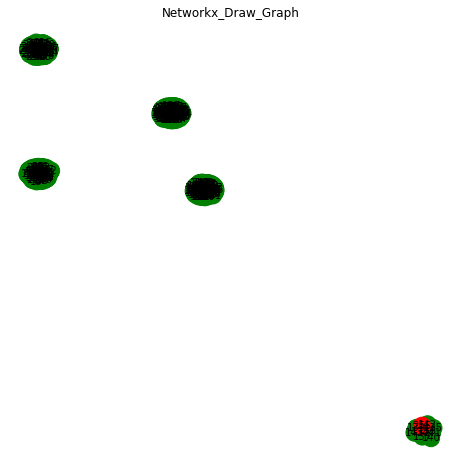

Counter edges per class:  [0. 0. 9. 0. 0.]
Mean probabilities per class:  [0.0, 0.0, 0.8914016962051392, 0.0, 0.0]
Weights per class:  [0.         0.         0.99044633 0.         0.        ]
Class predicted:  3
Real class:  1
##############################################################
4


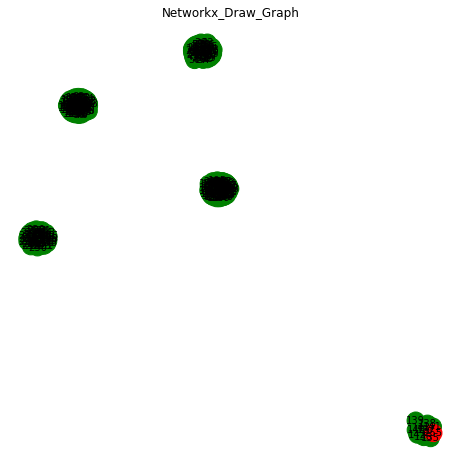

Counter edges per class:  [0. 0. 9. 0. 0.]
Mean probabilities per class:  [0.0, 0.0, 0.8902352035045624, 0.0, 0.0]
Weights per class:  [0.         0.         0.98915023 0.         0.        ]
Class predicted:  3
Real class:  1
##############################################################
5


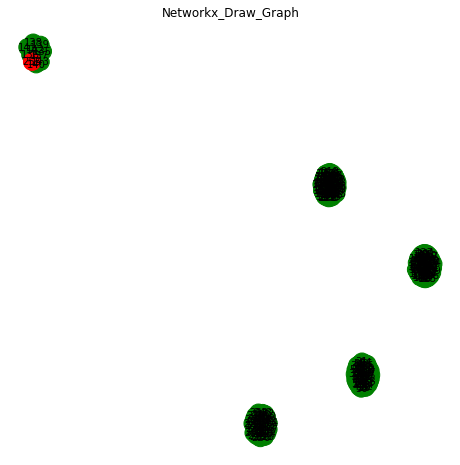

Counter edges per class:  [0. 0. 9. 0. 0.]
Mean probabilities per class:  [0.0, 0.0, 0.8887275874614715, 0.0, 0.0]
Weights per class:  [0.        0.        0.9874751 0.        0.       ]
Class predicted:  3
Real class:  1
##############################################################
6


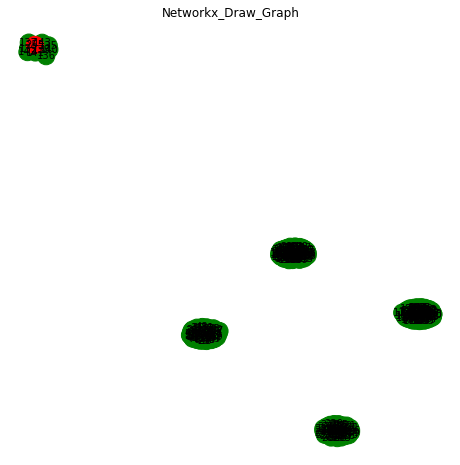

Counter edges per class:  [0. 0. 9. 0. 0.]
Mean probabilities per class:  [0.0, 0.0, 0.8949085235595703, 0.0, 0.0]
Weights per class:  [0.        0.        0.9943428 0.        0.       ]
Class predicted:  3
Real class:  1
##############################################################
7


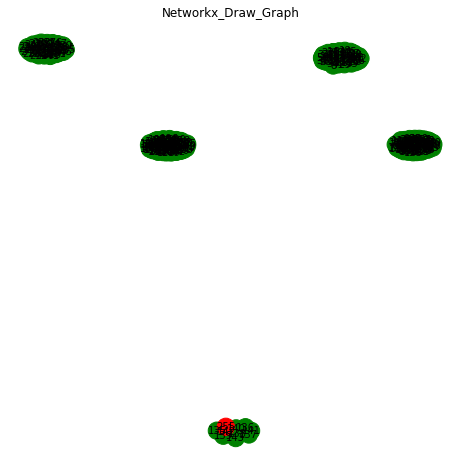

Counter edges per class:  [0. 0. 9. 0. 0.]
Mean probabilities per class:  [0.0, 0.0, 0.8750300824642181, 0.0, 0.0]
Weights per class:  [0.         0.         0.97225565 0.         0.        ]
Class predicted:  3
Real class:  1
##############################################################
8


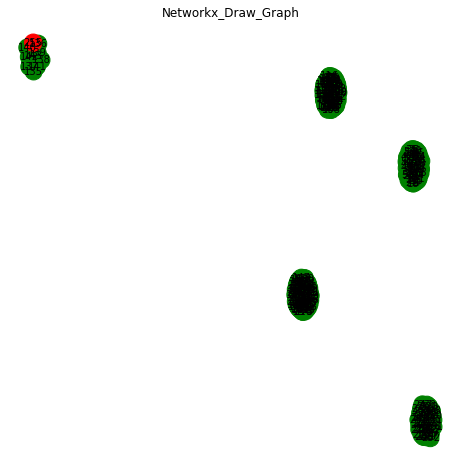

Counter edges per class:  [0. 0. 9. 0. 0.]
Mean probabilities per class:  [0.0, 0.0, 0.8887663185596466, 0.0, 0.0]
Weights per class:  [0.         0.         0.98751813 0.         0.        ]
Class predicted:  3
Real class:  1
##############################################################
9


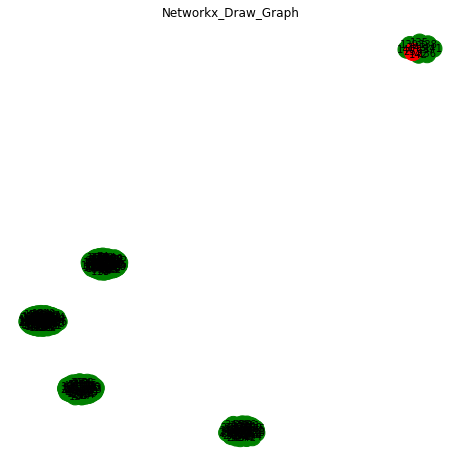

Counter edges per class:  [0. 0. 9. 0. 0.]
Mean probabilities per class:  [0.0, 0.0, 0.8863146722316741, 0.0, 0.0]
Weights per class:  [0.         0.         0.98479408 0.         0.        ]
Class predicted:  3
Real class:  1
##############################################################
10


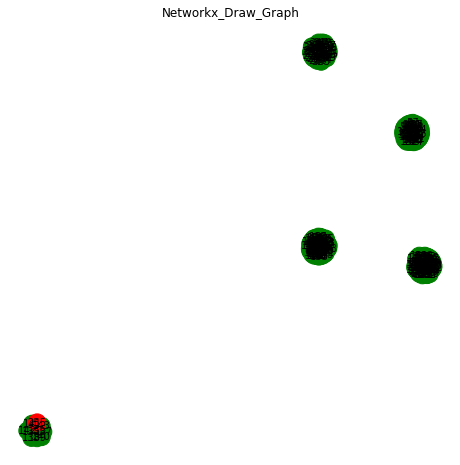

Counter edges per class:  [0. 0. 9. 0. 0.]
Mean probabilities per class:  [0.0, 0.0, 0.8910782754421234, 0.0, 0.0]
Weights per class:  [0.         0.         0.99008697 0.         0.        ]
Class predicted:  3
Real class:  1
##############################################################
11


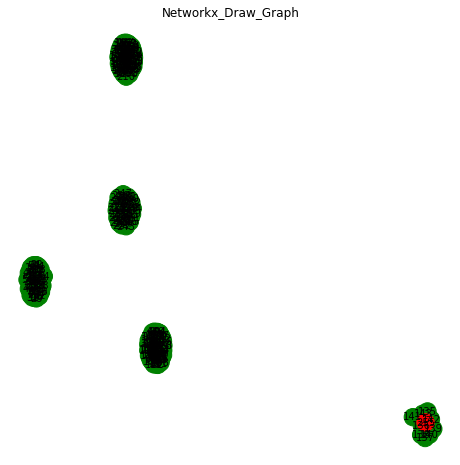

Counter edges per class:  [0. 0. 9. 0. 0.]
Mean probabilities per class:  [0.0, 0.0, 0.8501330137252807, 0.0, 0.0]
Weights per class:  [0.         0.         0.94459224 0.         0.        ]
Class predicted:  3
Real class:  1
##############################################################
12


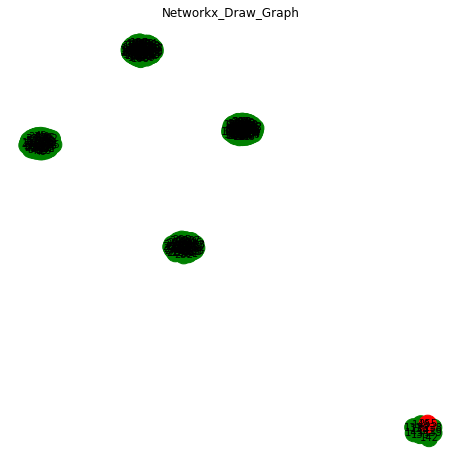

Counter edges per class:  [0. 0. 9. 0. 0.]
Mean probabilities per class:  [0.0, 0.0, 0.6970157861709595, 0.0, 0.0]
Weights per class:  [0.         0.         0.46467719 0.         0.        ]
Class predicted:  3
Real class:  1
##############################################################
13


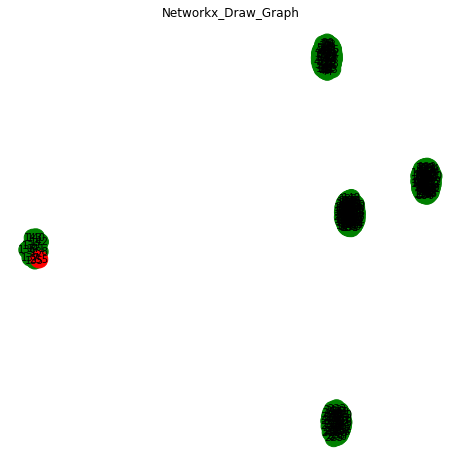

Counter edges per class:  [0. 0. 9. 0. 0.]
Mean probabilities per class:  [0.0, 0.0, 0.740908420085907, 0.0, 0.0]
Weights per class:  [0.         0.         0.65858526 0.         0.        ]
Class predicted:  3
Real class:  1
##############################################################
14


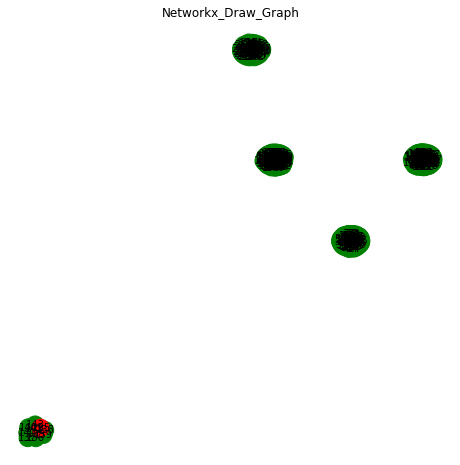

Counter edges per class:  [0. 0. 9. 0. 0.]
Mean probabilities per class:  [0.0, 0.0, 0.7760417103767395, 0.0, 0.0]
Weights per class:  [0.         0.         0.68981485 0.         0.        ]
Class predicted:  3
Real class:  1
##############################################################
15


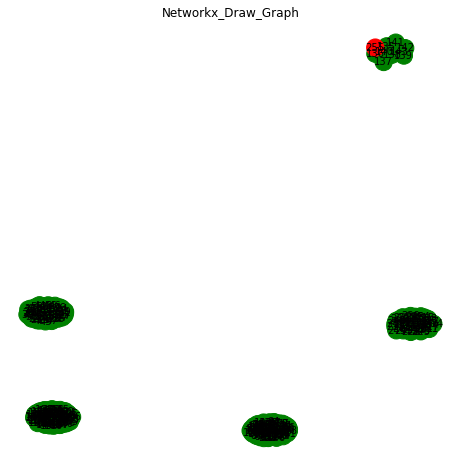

Counter edges per class:  [0. 0. 9. 0. 0.]
Mean probabilities per class:  [0.0, 0.0, 0.7621043622493744, 0.0, 0.0]
Weights per class:  [0.        0.        0.6774261 0.        0.       ]
Class predicted:  3
Real class:  2
##############################################################
16


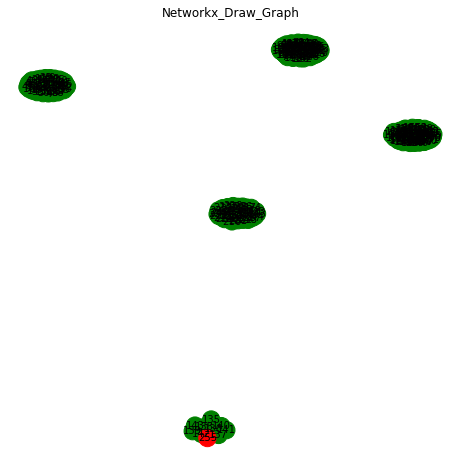

Counter edges per class:  [0. 0. 9. 0. 0.]
Mean probabilities per class:  [0.0, 0.0, 0.8968551635742188, 0.0, 0.0]
Weights per class:  [0.         0.         0.99650574 0.         0.        ]
Class predicted:  3
Real class:  2
##############################################################
17


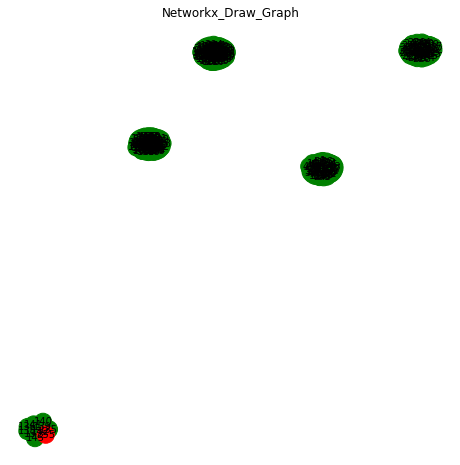

Counter edges per class:  [0. 0. 9. 0. 0.]
Mean probabilities per class:  [0.0, 0.0, 0.8741744577884674, 0.0, 0.0]
Weights per class:  [0.         0.         0.97130495 0.         0.        ]
Class predicted:  3
Real class:  2
##############################################################
18


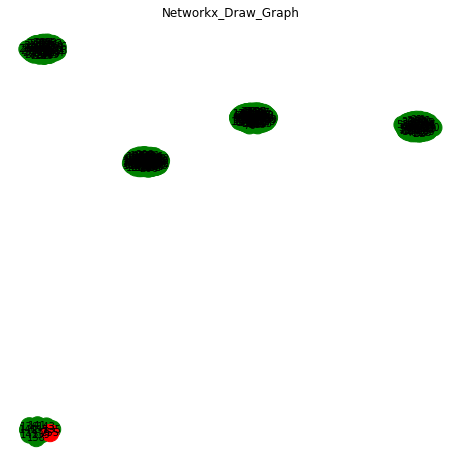

Counter edges per class:  [0. 0. 9. 0. 0.]
Mean probabilities per class:  [0.0, 0.0, 0.6275709807872772, 0.0, 0.0]
Weights per class:  [0.         0.         0.27892044 0.         0.        ]
Class predicted:  3
Real class:  2
##############################################################
19


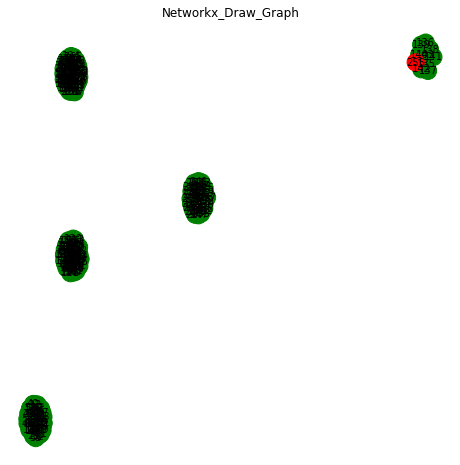

Counter edges per class:  [0. 0. 9. 0. 0.]
Mean probabilities per class:  [0.0, 0.0, 0.8610108733177185, 0.0, 0.0]
Weights per class:  [0.         0.         0.95667875 0.         0.        ]
Class predicted:  3
Real class:  2
##############################################################
20


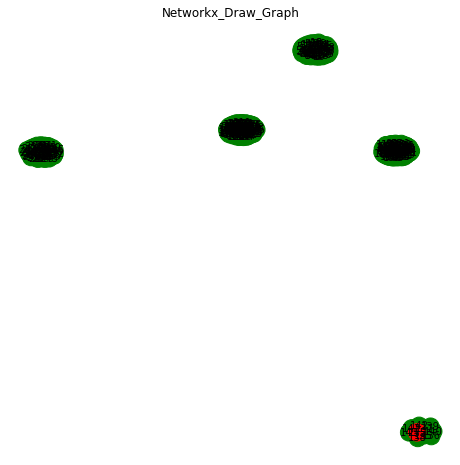

Counter edges per class:  [0. 0. 9. 0. 0.]
Mean probabilities per class:  [0.0, 0.0, 0.8874880313873291, 0.0, 0.0]
Weights per class:  [0.         0.         0.98609781 0.         0.        ]
Class predicted:  3
Real class:  2
##############################################################
21


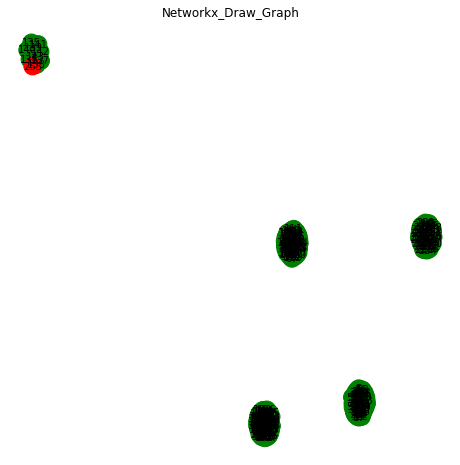

Counter edges per class:  [0. 0. 9. 0. 0.]
Mean probabilities per class:  [0.0, 0.0, 0.8914467573165894, 0.0, 0.0]
Weights per class:  [0.        0.        0.9904964 0.        0.       ]
Class predicted:  3
Real class:  2
##############################################################
22


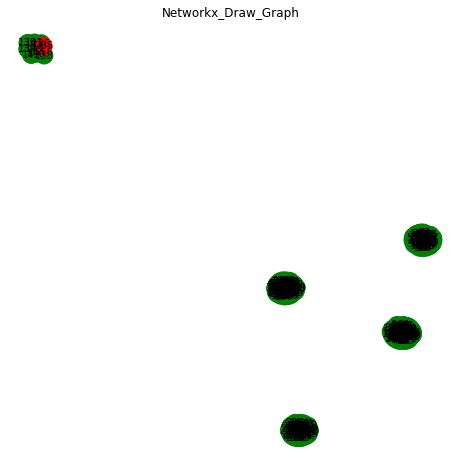

Counter edges per class:  [0. 0. 9. 0. 0.]
Mean probabilities per class:  [0.0, 0.0, 0.8663933157920838, 0.0, 0.0]
Weights per class:  [0.         0.         0.96265924 0.         0.        ]
Class predicted:  3
Real class:  2
##############################################################
23


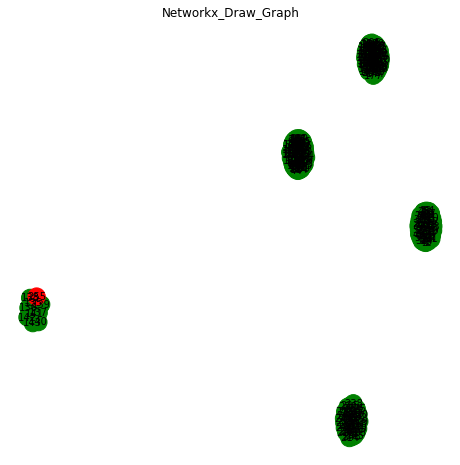

Counter edges per class:  [0. 0. 9. 0. 0.]
Mean probabilities per class:  [0.0, 0.0, 0.8587599098682404, 0.0, 0.0]
Weights per class:  [0.         0.         0.95417768 0.         0.        ]
Class predicted:  3
Real class:  2
##############################################################
24


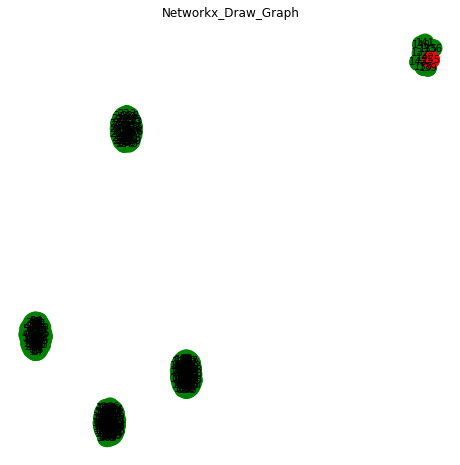

Counter edges per class:  [0. 0. 9. 0. 0.]
Mean probabilities per class:  [0.0, 0.0, 0.8828748464584351, 0.0, 0.0]
Weights per class:  [0.         0.         0.98097205 0.         0.        ]
Class predicted:  3
Real class:  2
##############################################################
25


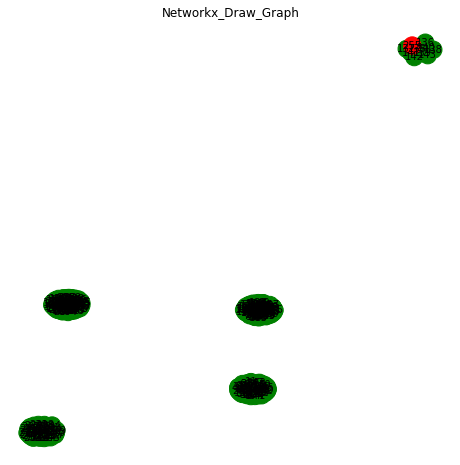

Counter edges per class:  [0. 0. 9. 0. 0.]
Mean probabilities per class:  [0.0, 0.0, 0.8935668289661407, 0.0, 0.0]
Weights per class:  [0.         0.         0.99285203 0.         0.        ]
Class predicted:  3
Real class:  2
##############################################################
26


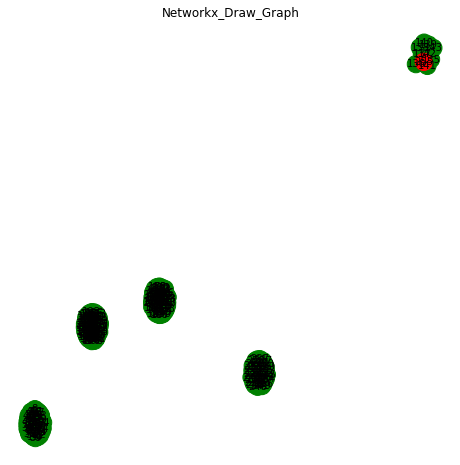

Counter edges per class:  [0. 0. 9. 0. 0.]
Mean probabilities per class:  [0.0, 0.0, 0.8964564263820648, 0.0, 0.0]
Weights per class:  [0.        0.        0.9960627 0.        0.       ]
Class predicted:  3
Real class:  2
##############################################################
27


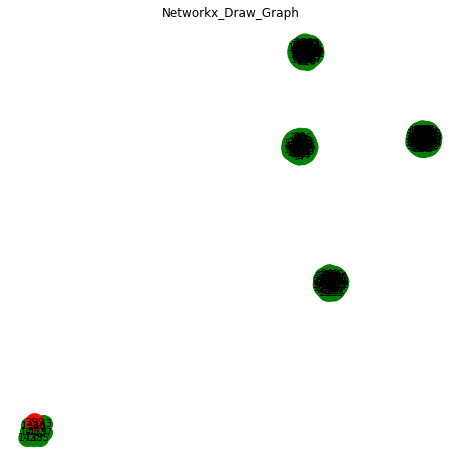

Counter edges per class:  [0. 0. 9. 0. 0.]
Mean probabilities per class:  [0.0, 0.0, 0.8998854160308838, 0.0, 0.0]
Weights per class:  [0.         0.         0.99987268 0.         0.        ]
Class predicted:  3
Real class:  2
##############################################################
28


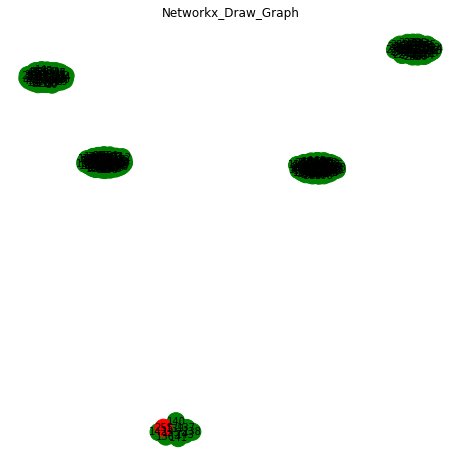

Counter edges per class:  [0. 0. 9. 0. 0.]
Mean probabilities per class:  [0.0, 0.0, 0.8814566016197205, 0.0, 0.0]
Weights per class:  [0.         0.         0.97939622 0.         0.        ]
Class predicted:  3
Real class:  2
##############################################################
29


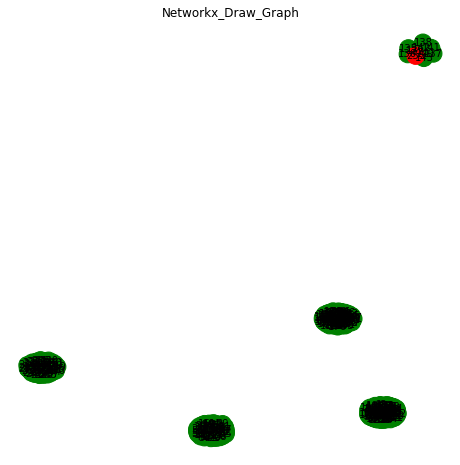

Counter edges per class:  [0. 0. 9. 0. 0.]
Mean probabilities per class:  [0.0, 0.0, 0.8759222388267517, 0.0, 0.0]
Weights per class:  [0.         0.         0.97324693 0.         0.        ]
Class predicted:  3
Real class:  2
##############################################################
30


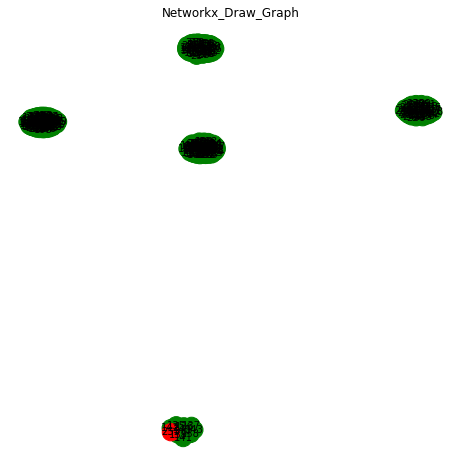

Counter edges per class:  [0. 0. 9. 0. 0.]
Mean probabilities per class:  [0.0, 0.0, 0.8690766513347625, 0.0, 0.0]
Weights per class:  [0.         0.         0.96564072 0.         0.        ]
Class predicted:  3
Real class:  2
##############################################################
31


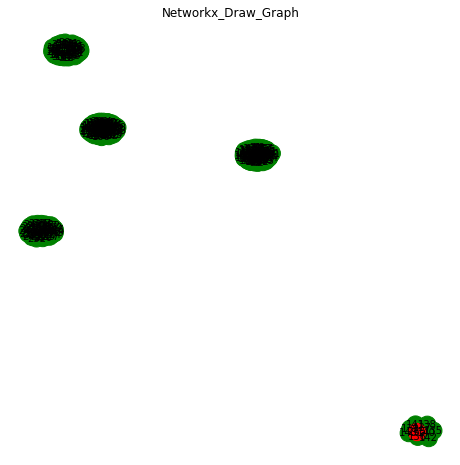

Counter edges per class:  [0. 0. 9. 0. 0.]
Mean probabilities per class:  [0.0, 0.0, 0.8944228291511536, 0.0, 0.0]
Weights per class:  [0.         0.         0.99380314 0.         0.        ]
Class predicted:  3
Real class:  2
##############################################################
32


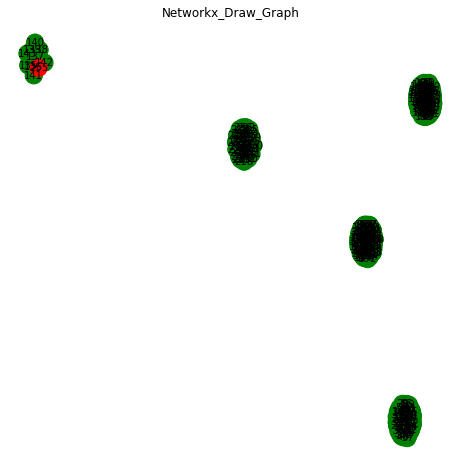

Counter edges per class:  [0. 0. 9. 0. 0.]
Mean probabilities per class:  [0.0, 0.0, 0.8922365605831146, 0.0, 0.0]
Weights per class:  [0.         0.         0.99137396 0.         0.        ]
Class predicted:  3
Real class:  2
##############################################################
33


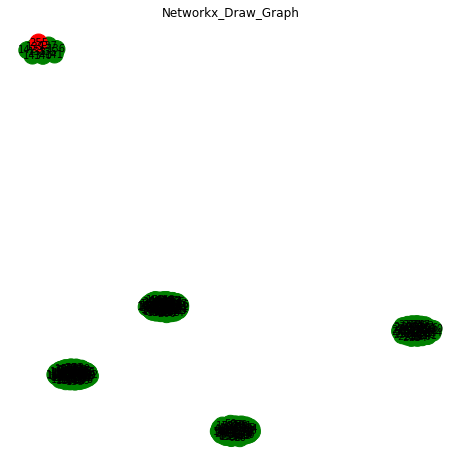

Counter edges per class:  [0. 0. 9. 0. 0.]
Mean probabilities per class:  [0.0, 0.0, 0.7023787021636962, 0.0, 0.0]
Weights per class:  [0.         0.         0.46825247 0.         0.        ]
Class predicted:  3
Real class:  2
##############################################################
34


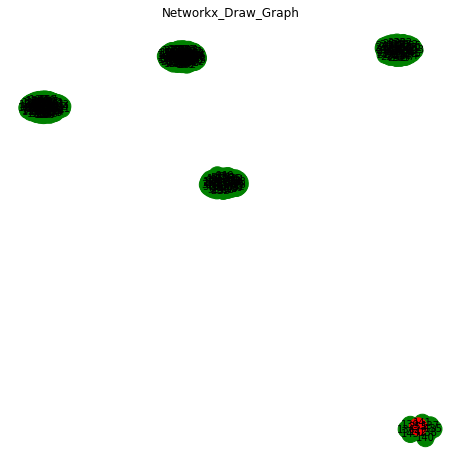

Counter edges per class:  [0. 0. 9. 0. 0.]
Mean probabilities per class:  [0.0, 0.0, 0.8133194267749786, 0.0, 0.0]
Weights per class:  [0.         0.         0.81331943 0.         0.        ]
Class predicted:  3
Real class:  3
##############################################################
35


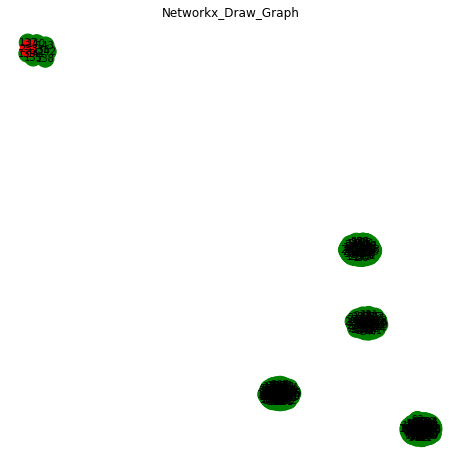

Counter edges per class:  [0. 0. 9. 0. 0.]
Mean probabilities per class:  [0.0, 0.0, 0.8474483907222747, 0.0, 0.0]
Weights per class:  [0.         0.         0.84744839 0.         0.        ]
Class predicted:  3
Real class:  3
##############################################################
36


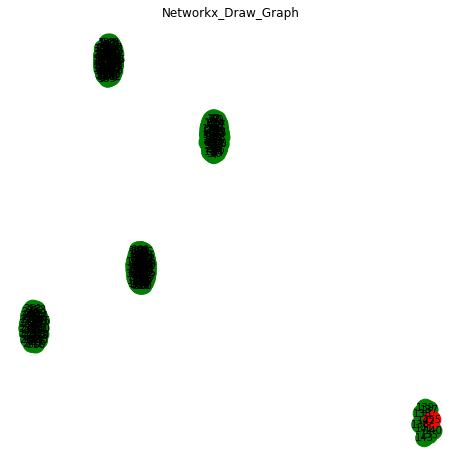

Counter edges per class:  [0. 0. 9. 0. 0.]
Mean probabilities per class:  [0.0, 0.0, 0.6785624027252197, 0.0, 0.0]
Weights per class:  [0.         0.         0.45237494 0.         0.        ]
Class predicted:  3
Real class:  4
##############################################################
37


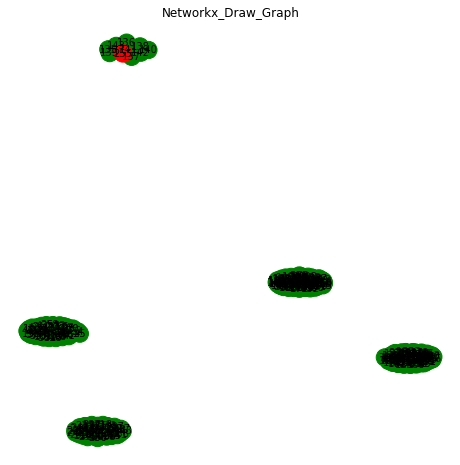

Counter edges per class:  [0. 0. 9. 0. 0.]
Mean probabilities per class:  [0.0, 0.0, 0.8146730840206147, 0.0, 0.0]
Weights per class:  [0.         0.         0.90519232 0.         0.        ]
Class predicted:  3
Real class:  4
##############################################################
38


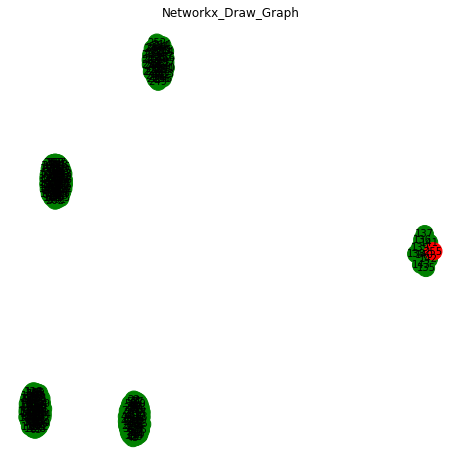

Counter edges per class:  [0. 0. 9. 0. 0.]
Mean probabilities per class:  [0.0, 0.0, 0.6046202301979064, 0.0, 0.0]
Weights per class:  [0.        0.        0.2687201 0.        0.       ]
Class predicted:  3
Real class:  4
##############################################################
39


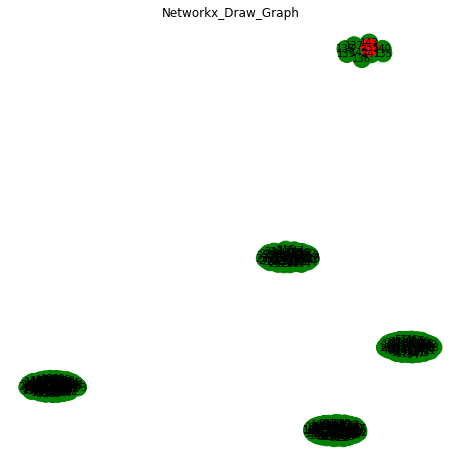

Counter edges per class:  [0. 0. 9. 0. 0.]
Mean probabilities per class:  [0.0, 0.0, 0.6207593500614166, 0.0, 0.0]
Weights per class:  [0.         0.         0.27589304 0.         0.        ]
Class predicted:  3
Real class:  4
##############################################################
40


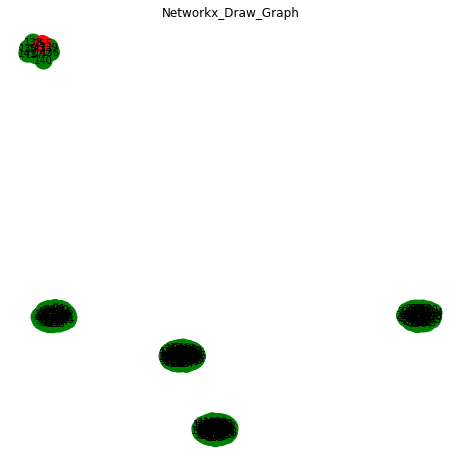

Counter edges per class:  [0. 0. 9. 0. 0.]
Mean probabilities per class:  [0.0, 0.0, 0.5765911996364593, 0.0, 0.0]
Weights per class:  [0.         0.         0.25626276 0.         0.        ]
Class predicted:  3
Real class:  4
##############################################################
41


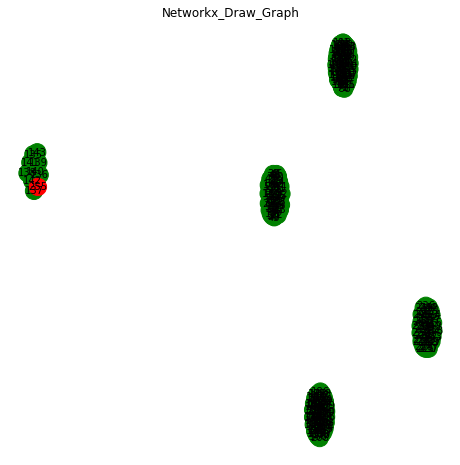

Counter edges per class:  [0. 0. 9. 0. 0.]
Mean probabilities per class:  [0.0, 0.0, 0.8041968047618866, 0.0, 0.0]
Weights per class:  [0.        0.        0.7148416 0.        0.       ]
Class predicted:  3
Real class:  4
##############################################################
42


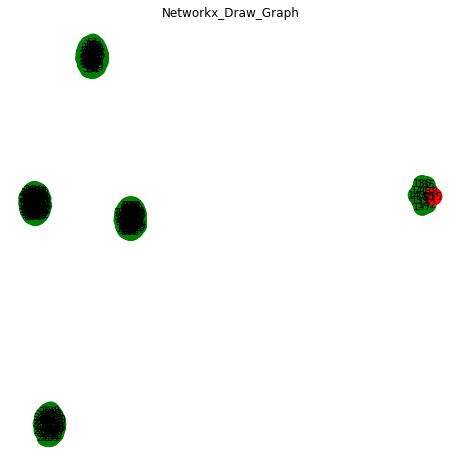

Counter edges per class:  [0. 0. 9. 0. 0.]
Mean probabilities per class:  [0.0, 0.0, 0.7448601722717285, 0.0, 0.0]
Weights per class:  [0.         0.         0.66209793 0.         0.        ]
Class predicted:  3
Real class:  4
##############################################################
43


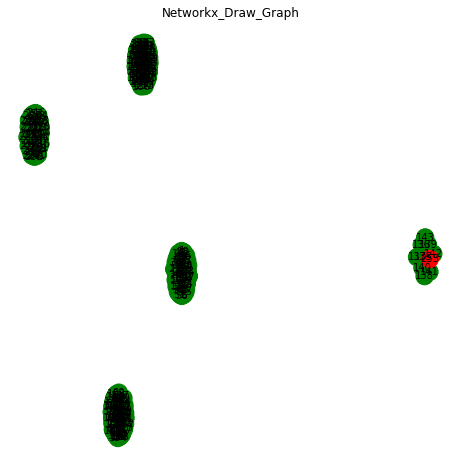

Counter edges per class:  [0. 0. 9. 0. 0.]
Mean probabilities per class:  [0.0, 0.0, 0.8609352886676789, 0.0, 0.0]
Weights per class:  [0.         0.         0.95659477 0.         0.        ]
Class predicted:  3
Real class:  4
##############################################################
44


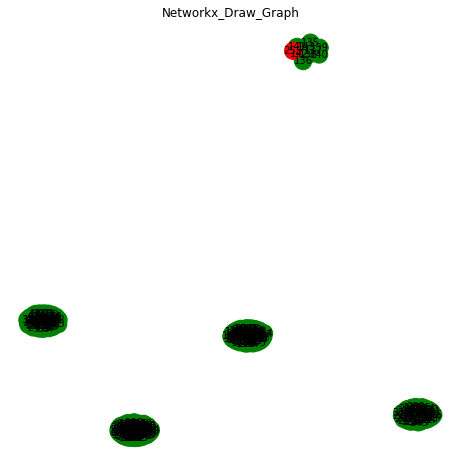

Counter edges per class:  [0. 0. 9. 0. 0.]
Mean probabilities per class:  [0.0, 0.0, 0.831535917520523, 0.0, 0.0]
Weights per class:  [0.        0.        0.9239288 0.        0.       ]
Class predicted:  3
Real class:  4
##############################################################
45


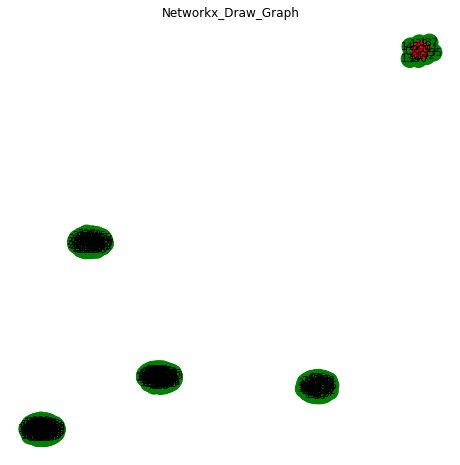

Counter edges per class:  [0. 0. 9. 0. 0.]
Mean probabilities per class:  [0.0, 0.0, 0.6925787150859832, 0.0, 0.0]
Weights per class:  [0.         0.         0.46171914 0.         0.        ]
Class predicted:  3
Real class:  4
##############################################################
46


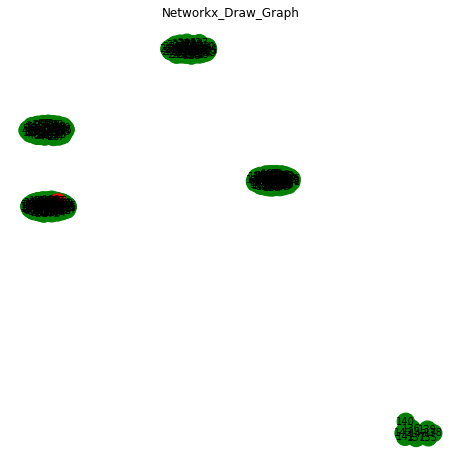

Counter edges per class:  [ 0.  0.  0. 70.  0.]
Mean probabilities per class:  [0.0, 0.0, 0.0, 0.7618583423990599, 0.0]
Weights per class:  [0.         0.         0.         0.45711501 0.        ]
Class predicted:  4
Real class:  4
##############################################################
47


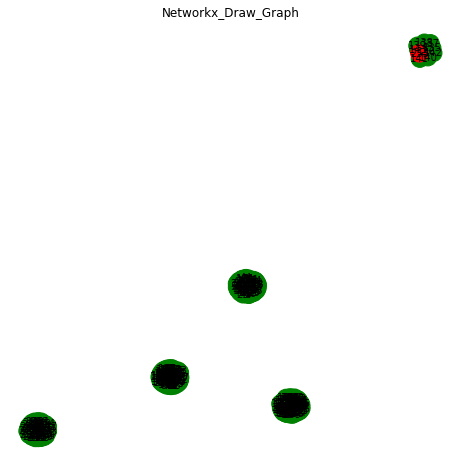

Counter edges per class:  [0. 0. 9. 0. 0.]
Mean probabilities per class:  [0.0, 0.0, 0.7880507111549377, 0.0, 0.0]
Weights per class:  [0.         0.         0.70048952 0.         0.        ]
Class predicted:  3
Real class:  4
##############################################################
48


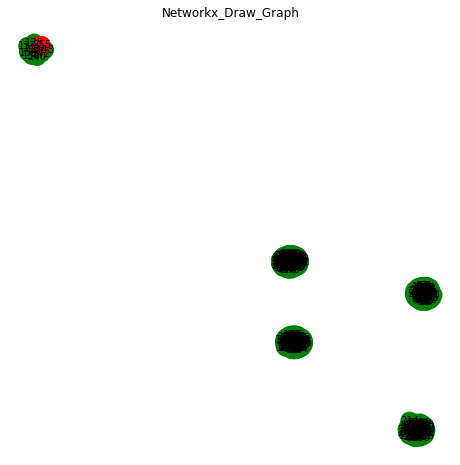

Counter edges per class:  [0. 0. 9. 0. 0.]
Mean probabilities per class:  [0.0, 0.0, 0.732332968711853, 0.0, 0.0]
Weights per class:  [0.         0.         0.65096264 0.         0.        ]
Class predicted:  3
Real class:  4
##############################################################
49


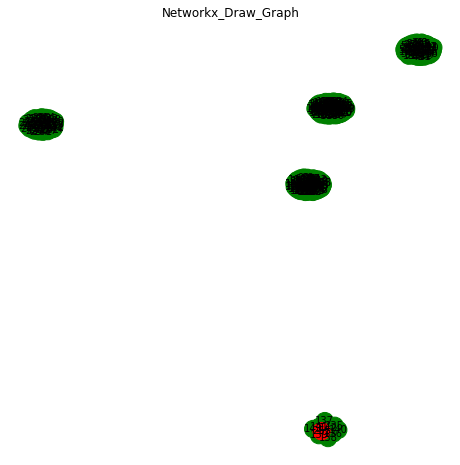

Counter edges per class:  [0. 0. 9. 0. 0.]
Mean probabilities per class:  [0.0, 0.0, 0.7478095293045044, 0.0, 0.0]
Weights per class:  [0.         0.         0.66471958 0.         0.        ]
Class predicted:  3
Real class:  4
##############################################################
50


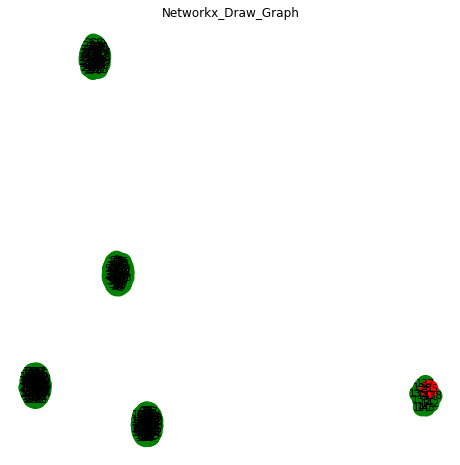

Counter edges per class:  [0. 0. 9. 0. 0.]
Mean probabilities per class:  [0.0, 0.0, 0.7882547736167907, 0.0, 0.0]
Weights per class:  [0.         0.         0.70067091 0.         0.        ]
Class predicted:  3
Real class:  4
##############################################################
51


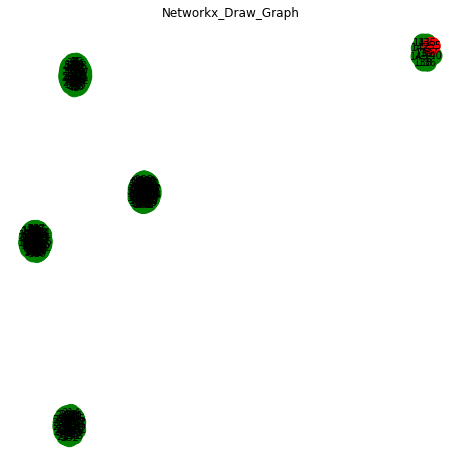

Counter edges per class:  [0. 0. 9. 0. 0.]
Mean probabilities per class:  [0.0, 0.0, 0.7166088938713073, 0.0, 0.0]
Weights per class:  [0.         0.         0.47773926 0.         0.        ]
Class predicted:  3
Real class:  4
##############################################################
52


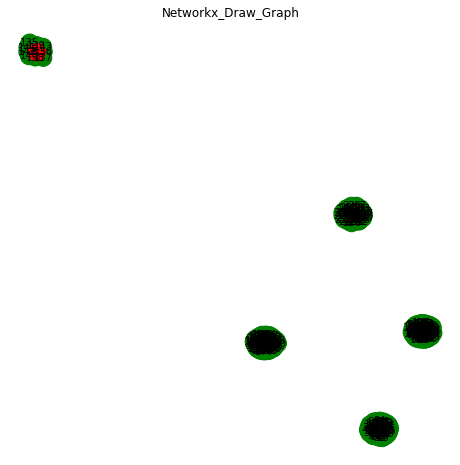

Counter edges per class:  [0. 0. 9. 0. 0.]
Mean probabilities per class:  [0.0, 0.0, 0.8256148338317871, 0.0, 0.0]
Weights per class:  [0.         0.         0.91734982 0.         0.        ]
Class predicted:  3
Real class:  4
##############################################################
53


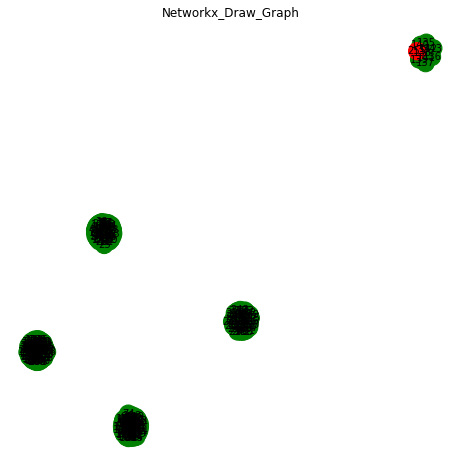

Counter edges per class:  [0. 0. 9. 0. 0.]
Mean probabilities per class:  [0.0, 0.0, 0.5048437178134918, 0.0, 0.0]
Weights per class:  [0.         0.         0.11218749 0.         0.        ]
Class predicted:  3
Real class:  4
##############################################################
54


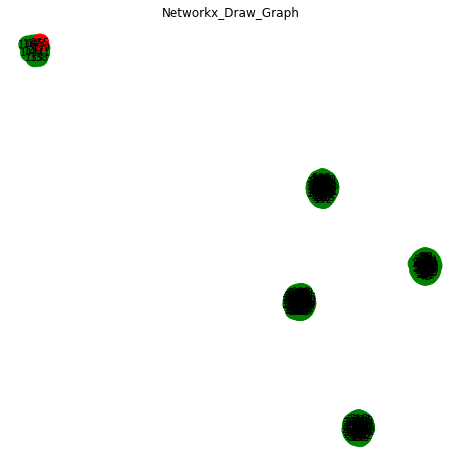

Counter edges per class:  [0. 0. 9. 0. 0.]
Mean probabilities per class:  [0.0, 0.0, 0.5340494871139526, 0.0, 0.0]
Weights per class:  [0.         0.         0.11867766 0.         0.        ]
Class predicted:  3
Real class:  4
##############################################################
55


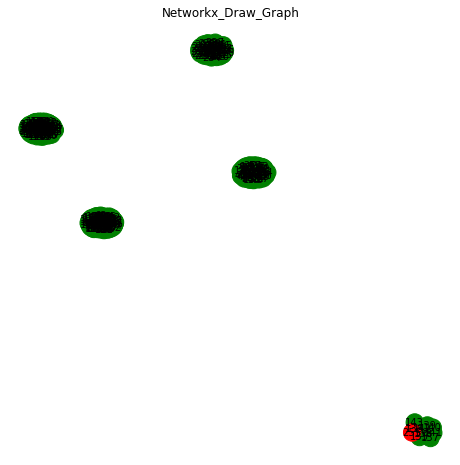

Counter edges per class:  [0. 0. 9. 0. 0.]
Mean probabilities per class:  [0.0, 0.0, 0.8949576616287231, 0.0, 0.0]
Weights per class:  [0.        0.        0.9943974 0.        0.       ]
Class predicted:  3
Real class:  5
##############################################################
56


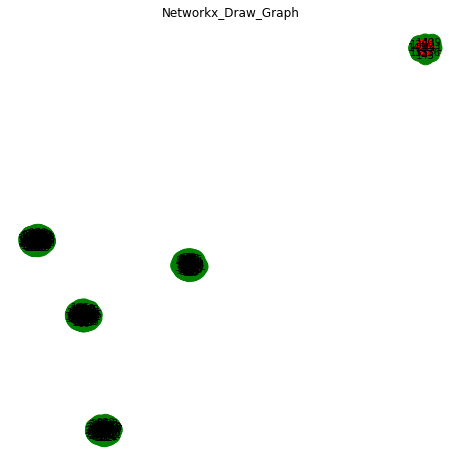

Counter edges per class:  [0. 0. 9. 0. 0.]
Mean probabilities per class:  [0.0, 0.0, 0.8953463137149811, 0.0, 0.0]
Weights per class:  [0.         0.         0.99482924 0.         0.        ]
Class predicted:  3
Real class:  5
##############################################################
57


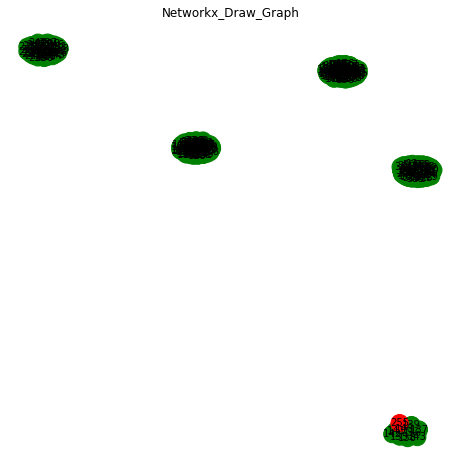

Counter edges per class:  [0. 0. 9. 0. 0.]
Mean probabilities per class:  [0.0, 0.0, 0.5614295840263367, 0.0, 0.0]
Weights per class:  [0.         0.         0.24952426 0.         0.        ]
Class predicted:  3
Real class:  5
##############################################################
58


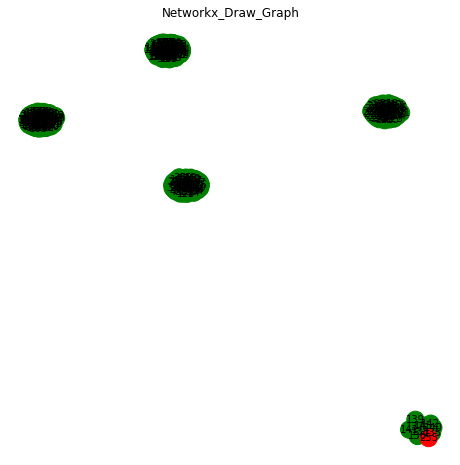

Counter edges per class:  [0. 0. 9. 0. 0.]
Mean probabilities per class:  [0.0, 0.0, 0.8567096829414368, 0.0, 0.0]
Weights per class:  [0.         0.         0.95189965 0.         0.        ]
Class predicted:  3
Real class:  5
##############################################################
59


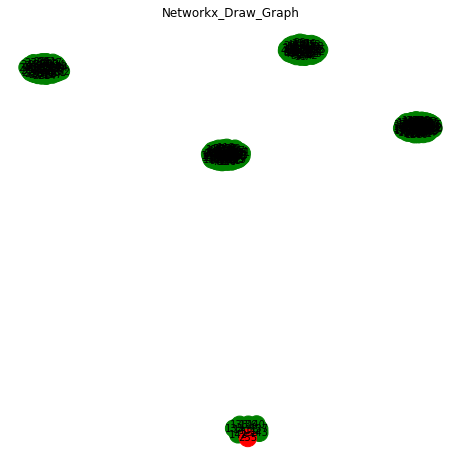

Counter edges per class:  [0. 0. 9. 0. 0.]
Mean probabilities per class:  [0.0, 0.0, 0.7267871260643005, 0.0, 0.0]
Weights per class:  [0.       0.       0.646033 0.       0.      ]
Class predicted:  3
Real class:  5
##############################################################
60


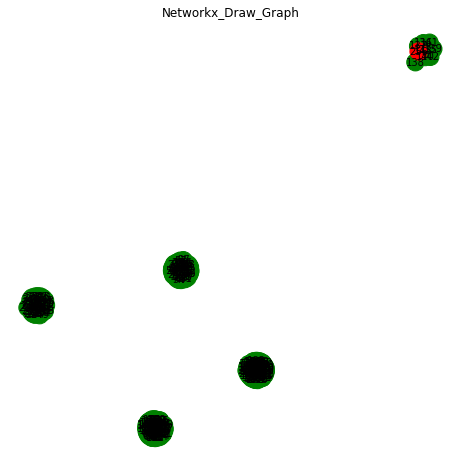

Counter edges per class:  [0. 0. 9. 0. 0.]
Mean probabilities per class:  [0.0, 0.0, 0.8500997006893158, 0.0, 0.0]
Weights per class:  [0.         0.         0.94455522 0.         0.        ]
Class predicted:  3
Real class:  5
##############################################################
61


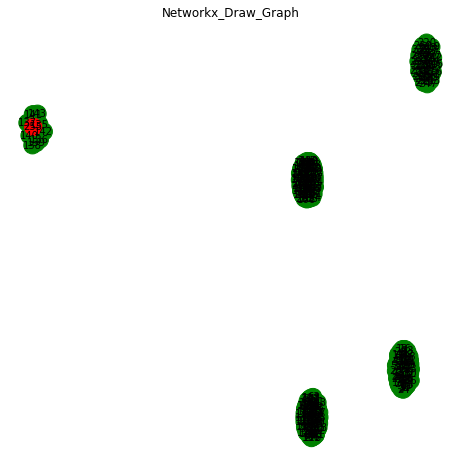

Counter edges per class:  [0. 0. 9. 0. 0.]
Mean probabilities per class:  [0.0, 0.0, 0.8193929135799408, 0.0, 0.0]
Weights per class:  [0.         0.         0.91043657 0.         0.        ]
Class predicted:  3
Real class:  5
##############################################################
62


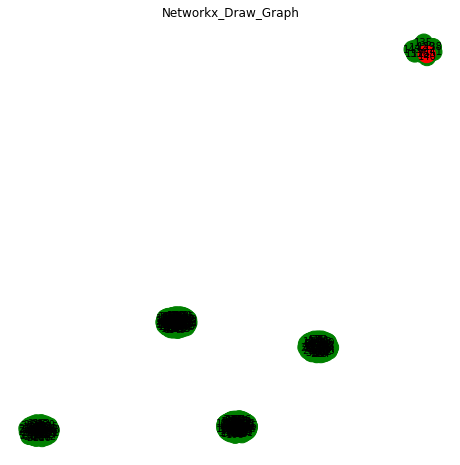

Counter edges per class:  [0. 0. 9. 0. 0.]
Mean probabilities per class:  [0.0, 0.0, 0.7770610570907592, 0.0, 0.0]
Weights per class:  [0.         0.         0.69072094 0.         0.        ]
Class predicted:  3
Real class:  5
##############################################################
63


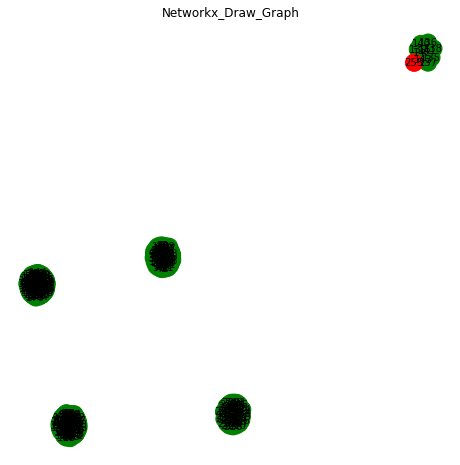

Counter edges per class:  [0. 0. 9. 0. 0.]
Mean probabilities per class:  [0.0, 0.0, 0.6114960730075836, 0.0, 0.0]
Weights per class:  [0.         0.         0.27177603 0.         0.        ]
Class predicted:  3
Real class:  5
***********************************************************
The test accuracy is:  0.046875
[[ 9  1  3  2  0]
 [ 3  9  3  2  2]
 [ 0  0  0  2  0]
 [ 0  0  0 19  0]
 [ 1  0  1  5  2]]


In [ ]:
##### Load test data - Mode: node_test linked to ALL nodes of input graph ######

accuracy_test = 0
y_test_predicted2 = []
y_test_true_class2 = []

for idx_node_test in range (0,len(profiles_new)):

  node_test = len(profiles)
  class_instances_test = class_instances_train.copy()
  class_node = int(map_datasets_test[str(node_test+idx_node_test)][0]) - 1
  class_instances_test[class_node] += 1

  print("##############################################################")
  print(idx_node_test)
  #### Insert test data to train data ####
  node_test = len(profiles)

  list_edges_test = list_edges.copy()

  for i in range (0,node_test+1):
    list_edges_test.append([i,node_test])
    list_edges_test.append([node_test,i])
  list_edges_test.append([node_test,node_test])

  edge_index_test = torch.tensor(list_edges_test, dtype=torch.long)

  profiles_test = profiles.copy()
  profiles_test.append(profiles_new[idx_node_test])

  x = torch.tensor(profiles_test, dtype=torch.float)
  data = Data(x=x, edge_index=edge_index_test.t().contiguous())


  ####### Make prediction ###########
  z = model_pre_test.encode()
  probs_test = model_pre_test.obtain_probs(z)
  final_edge_index = model_pre_test.decode_all(z)

  final_edge_index = final_edge_index.permute(1,0).unsqueeze(1)
  final_edge_index = final_edge_index.squeeze(1)

  draw_graph_from_nodelist(final_edge_index.tolist(), [1 for i in range(node_test+1)])

  out_edges = []
  in_edges = []
  for edge in final_edge_index:
      if edge[0] == node_test and edge[1] != node_test:
        out_edges.append(edge[1].item())
      if edge[1] == node_test and edge[0] != node_test:
        in_edges.append(edge[0].item())

  class_predicted = class_selector(node_test, out_edges, probs_test,class_instances_test)
  print("Class predicted: ", class_predicted)
  print("Real class: ", map_datasets_test[str(node_test+idx_node_test)][0])

  y_test_predicted2.append(str(class_predicted))
  y_test_true_class2.append(map_datasets_test[str(node_test+idx_node_test)][0])

  if(int(map_datasets_test[str(node_test+idx_node_test)][0]) == int(class_predicted)):
    accuracy_test += 1

accuracy_test = accuracy_test / len(profiles_new)

print("***********************************************************")
print("The test accuracy is: ", accuracy_test)


confusion_test = confusion_matrix(y_test_true_class, y_test_predicted)
print(confusion_test)

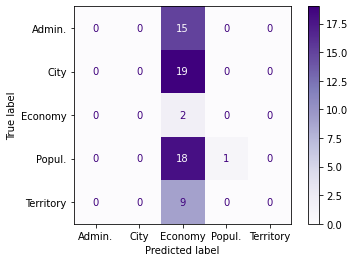

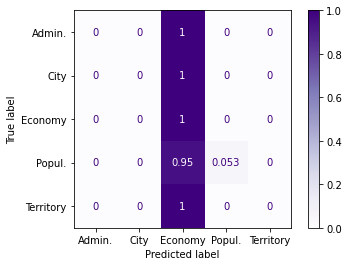

In [ ]:
title = [("GCNN Approach 2 Confusion Matrix", None),
         ("GCNN Approach 2 Normalized Confusion Matrix", 'true')]
class_names = ['Admin.', 'City', 'Economy','Popul.', 'Territory']
for title, normalize in title:
  cm = confusion_matrix(y_test_true_class2, y_test_predicted2, normalize = normalize)
  cmd = ConfusionMatrixDisplay(cm, display_labels= ['Admin.', 'City', 'Economy','Popul.', 'Territory'])
  cmd.plot(cmap = plt.cm.Purples)